In [174]:
import pandas as pd
import numpy as np

import jd 
from optbinning import MulticlassOptimalBinning

import plotly.express as px
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]  # Width, Height

from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

In [175]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)
"""

'\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ndf.status_group = le.fit_transform(df.status_group)\n'

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64


status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64

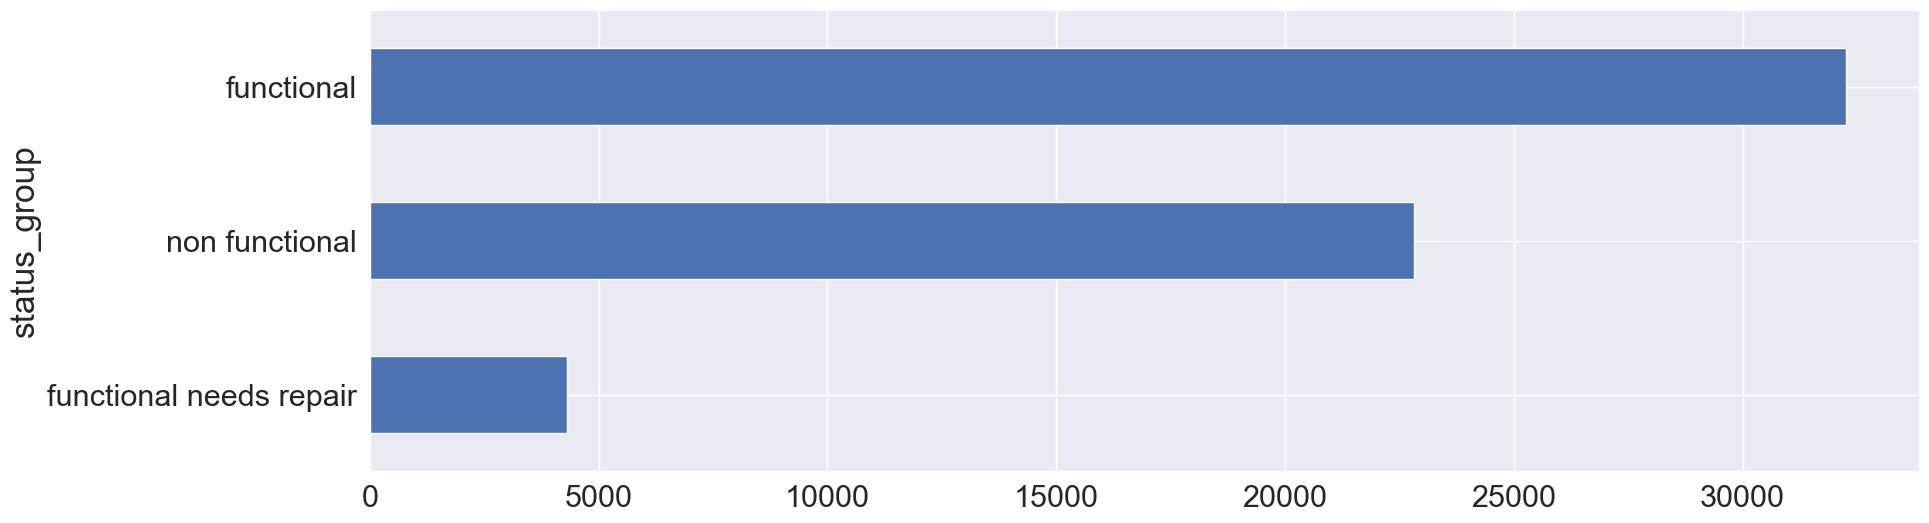

In [176]:
df.status_group.value_counts().sort_values().plot(kind="barh")
print(df.status_group.value_counts())
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)
df.status_group.value_counts()

### Label encoder me dejó labels fáciles de entender, 0 es lo mejor (funcional), luego nees repair (1), y como peor 2, non functional

In [177]:
for i in df.select_dtypes(include = "O").columns:
    df[i] = df[i].astype("category")

In [178]:
df.funder.dtype.name

'category'

In [179]:
df["random"] = np.random.uniform(0,1, size=df.shape[0])
df["random2"] = np.random.uniform(0,1, size=df.shape[0])
a_sacar = ["date_recorded","funder"]
tablaCramer = pd.DataFrame(df.drop(a_sacar,axis=1).apply(lambda x: jd.cramers_v(x, df.status_group)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente al Beneficio').update_yaxes(categoryorder="total ascending")

# Tenemos unas categóricas con mucha asociación cramer con la objetivo, pero que tienen una cantidad bárbara de categorías

In [180]:
tablaCramer["tipo"] = [df[x].dtype.name for x in tablaCramer.index.tolist()]
tablaCramer["Cant_valores_unicos"] = [df[x].nunique() for x in tablaCramer.index.tolist()]
tablaCramer.sort_values(ascending=False,by="VCramer")



,VCramer,tipo,Cant_valores_unicos
status_group,1.000000,int32,3
wpt_name,0.809522,category,37399
subvillage,0.682880,category,19287
scheme_name,0.593358,category,2695
ward,0.469122,category,2092
installer,0.363391,category,2145
lga,0.311533,category,125
quantity_group,0.309240,category,5
quantity,0.309240,category,5
waterpoint_type,0.250426,category,7


In [181]:
#Al graficarlo me di cuenta
df.num_private = df.num_private.astype("category")

In [182]:
tablaCramer.loc["region_code"]

VCramer                0.084304
tipo                      int64
Cant_valores_unicos          27
Name: region_code, dtype: object

In [183]:
#mat = jd.get_cat_corr_mat(df.drop(a_sacar,axis=1))
#sns.heatmap(annot=True,cmap="coolwarm")

In [184]:
tablaCramer.index

Index(['id', 'amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'random', 'random2'],
      dtype='object')

In [185]:
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(20,12), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='red',linestyle='--')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data.dropna()),color='blue',linestyle='-')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    #if title: ax_box2.set(title=title, xlabel="")
    ax_box2.set(title=data.name, xlabel="")
    #leyenda
    plt.legend(handles=[
    plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Mean'),
    plt.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Median')
    ], labels=['Mean (-)', 'Median (--)'])

    # Mostrar gráfico
    plt.show()

In [186]:
df.dtypes

id                          int64
amount_tsh                float64
date_recorded            category
funder                   category
gps_height                  int64
installer                category
longitude                 float64
latitude                  float64
wpt_name                 category
num_private              category
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
recorded_by              category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_type_group    category
extraction_type_class    category
management               category
management_group         category
payment       

# Empiezo mi EDA de variables numéricas

## amount_tsh: complicada, muchos valores centrados en el cero, muchos outliers

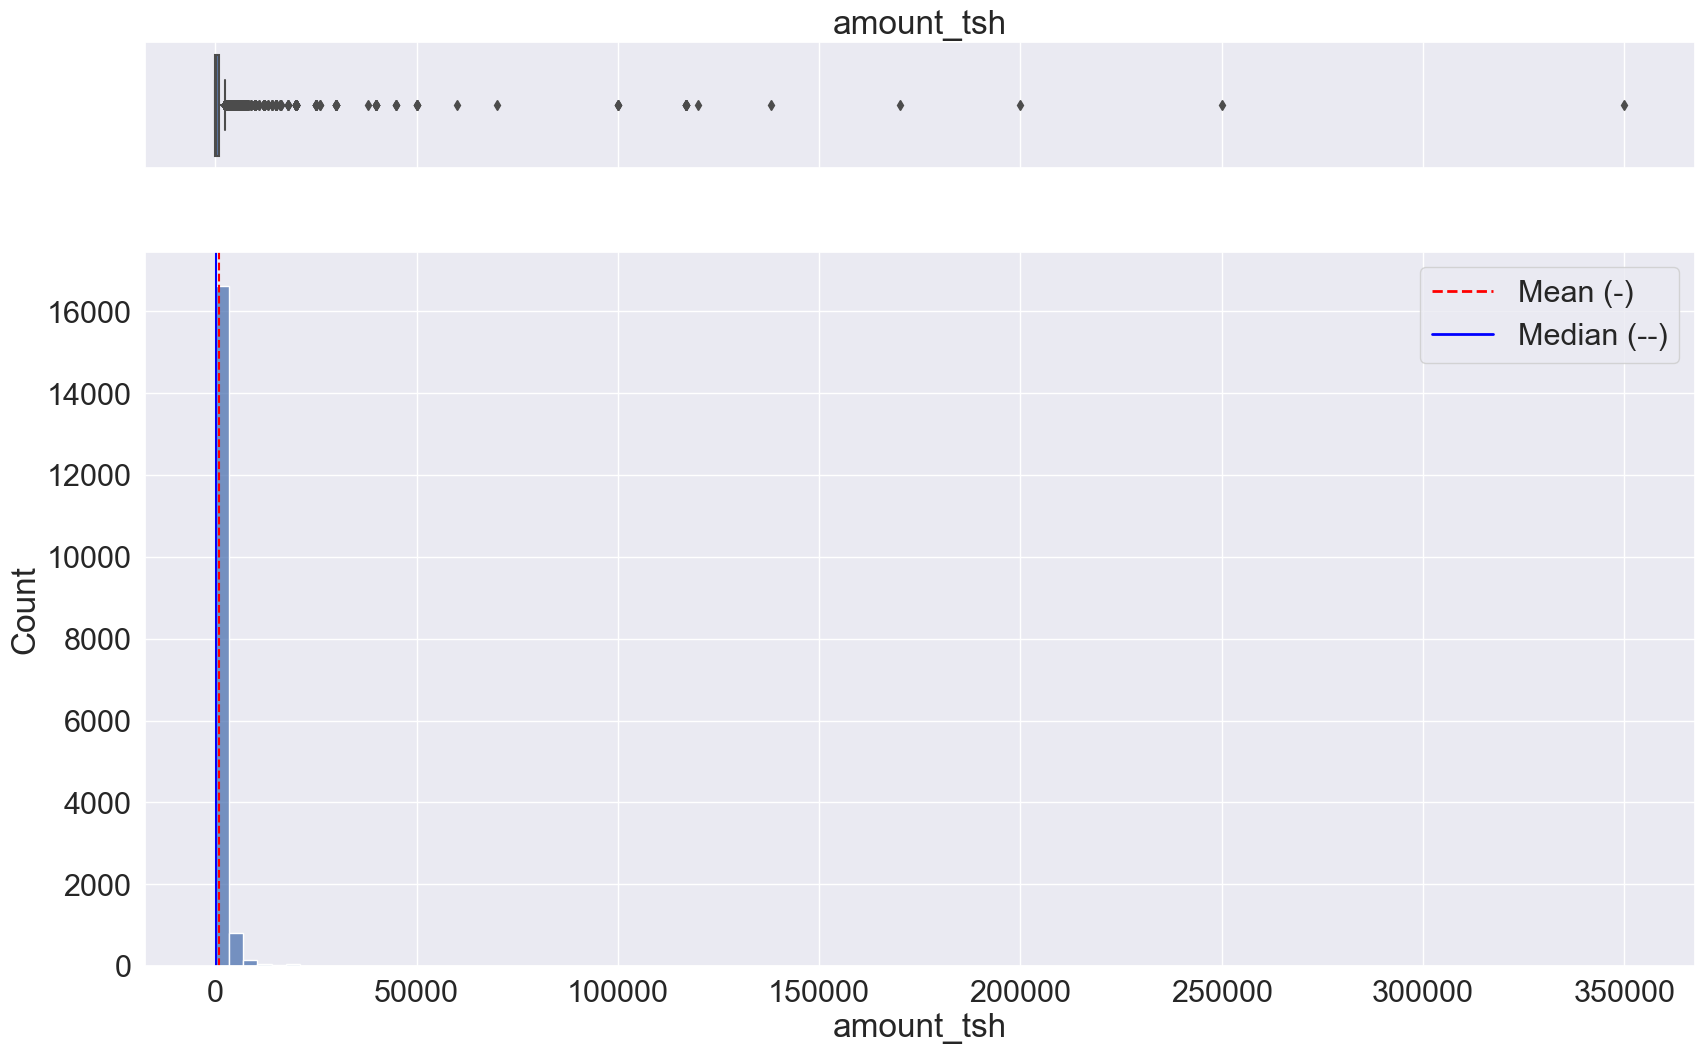

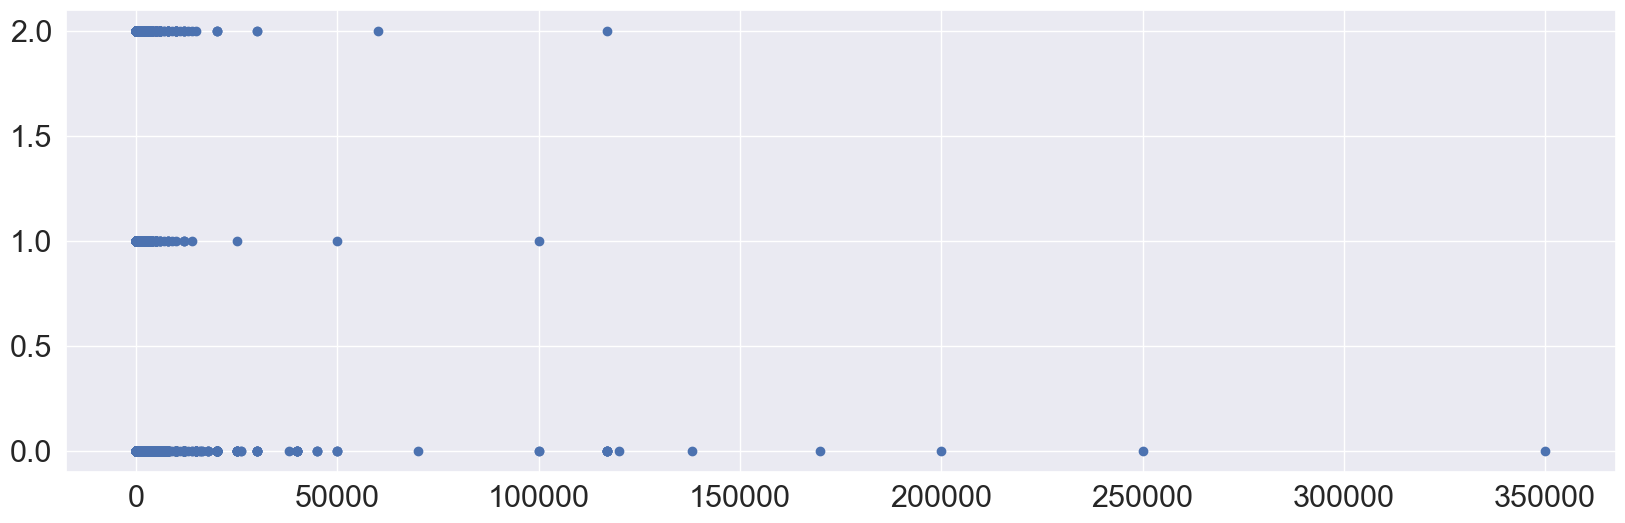

In [187]:
histogram_boxplot(df[df["amount_tsh"]!=0]["amount_tsh"],bins=100)
plt.show()
df[df["amount_tsh"]!=0]["amount_tsh"].value_counts().sort_index()
plt.scatter(x=df.amount_tsh,y=df.status_group)
plt.show()

Text(0.5, 1.0, 'Distribución tal cual')

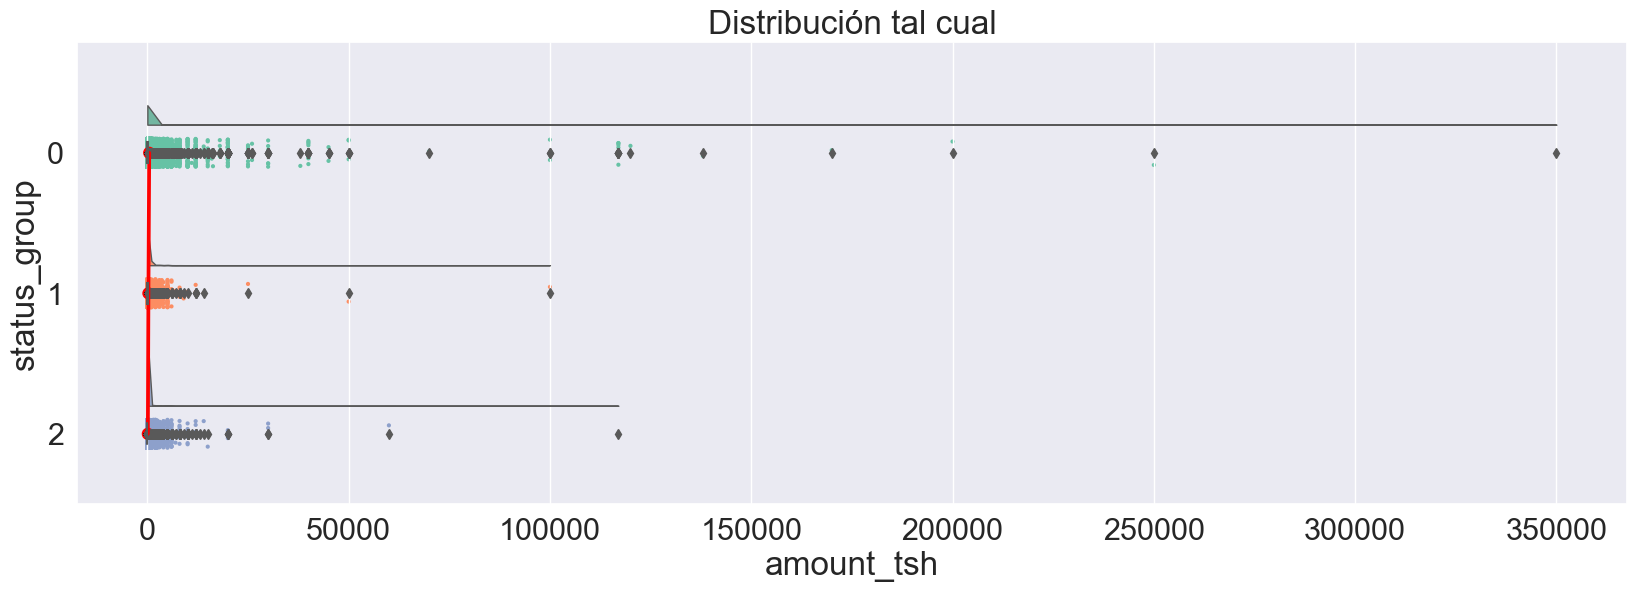

In [188]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Sacando outliers >50000')

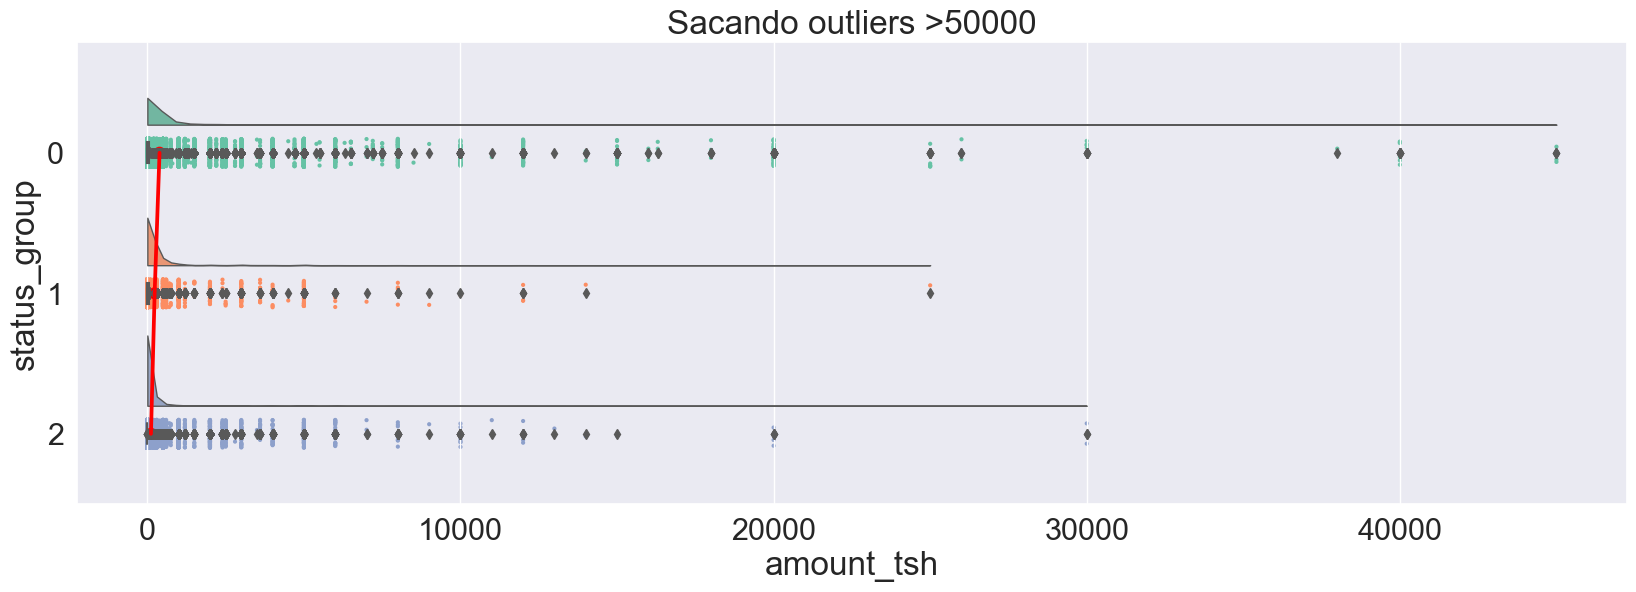

In [189]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[df["amount_tsh"]<50000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >50000")

status_group
0    19706
2    18885
1     3048
Name: count, dtype: int64

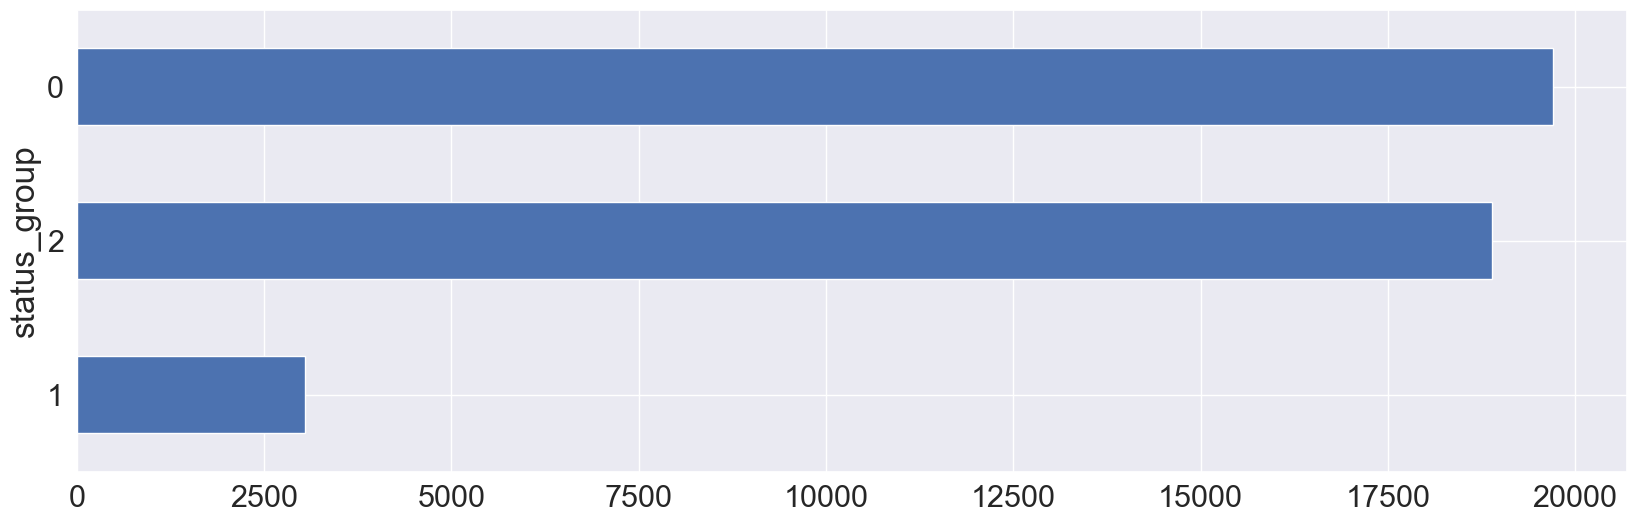

In [190]:
df[df["amount_tsh"]==0]["status_group"].value_counts().sort_values().plot(kind="barh")
df[df["amount_tsh"]==0]["status_group"].value_counts()

Text(0.5, 1.0, 'Sacando outliers >50000 y valores 0')

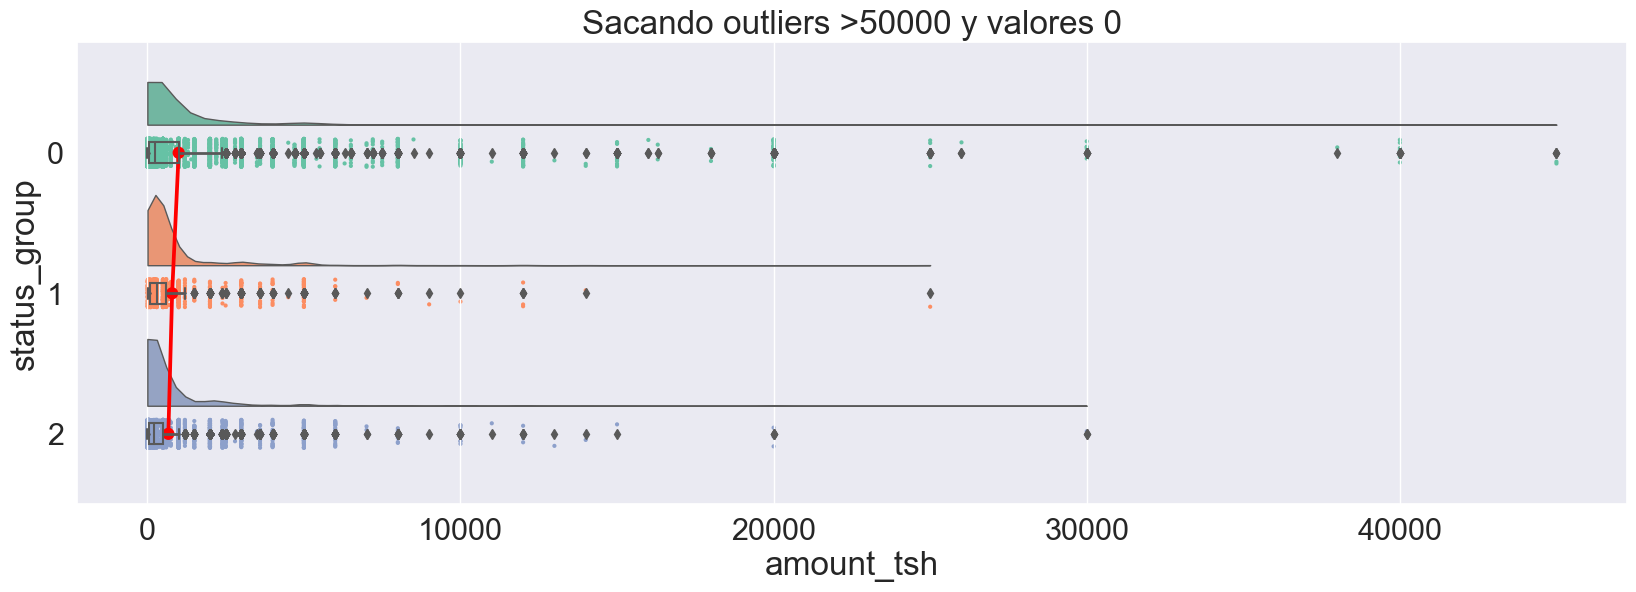

In [191]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<50000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >50000 y valores 0")

Text(0.5, 1.0, 'Sacando outliers >10000 y valores 0')

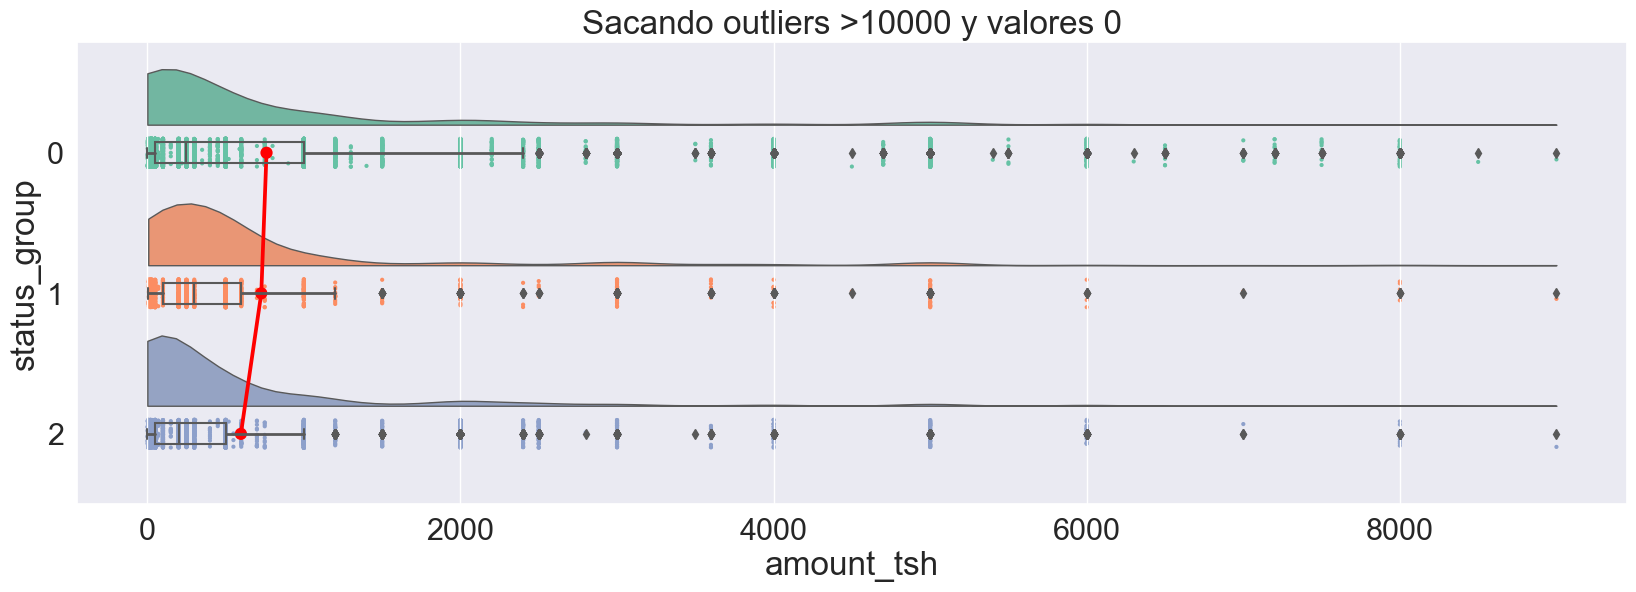

In [192]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<10000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >10000 y valores 0")

Text(0.5, 1.0, 'Sacando valores >2000 y valores 0')

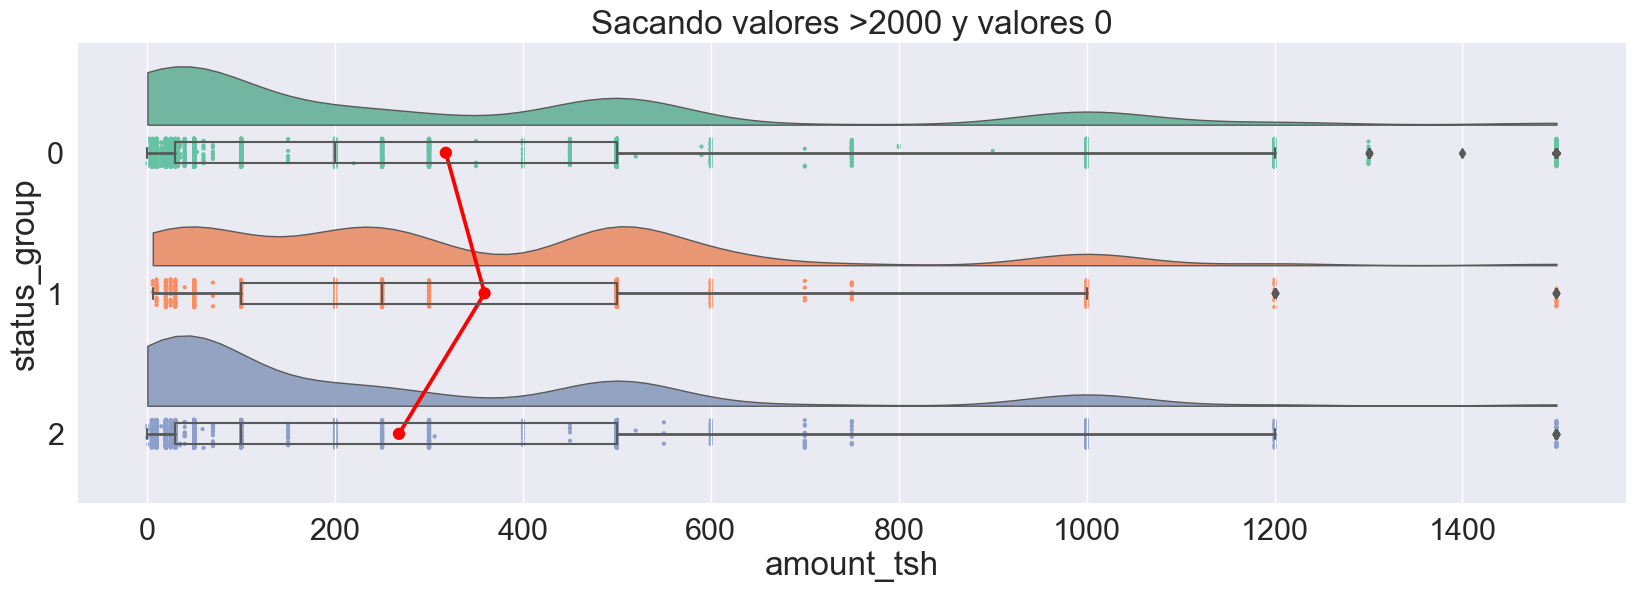

In [193]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<2000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando valores >2000 y valores 0")

# gps_height

Text(0.5, 1.0, 'Distribución tal cual')

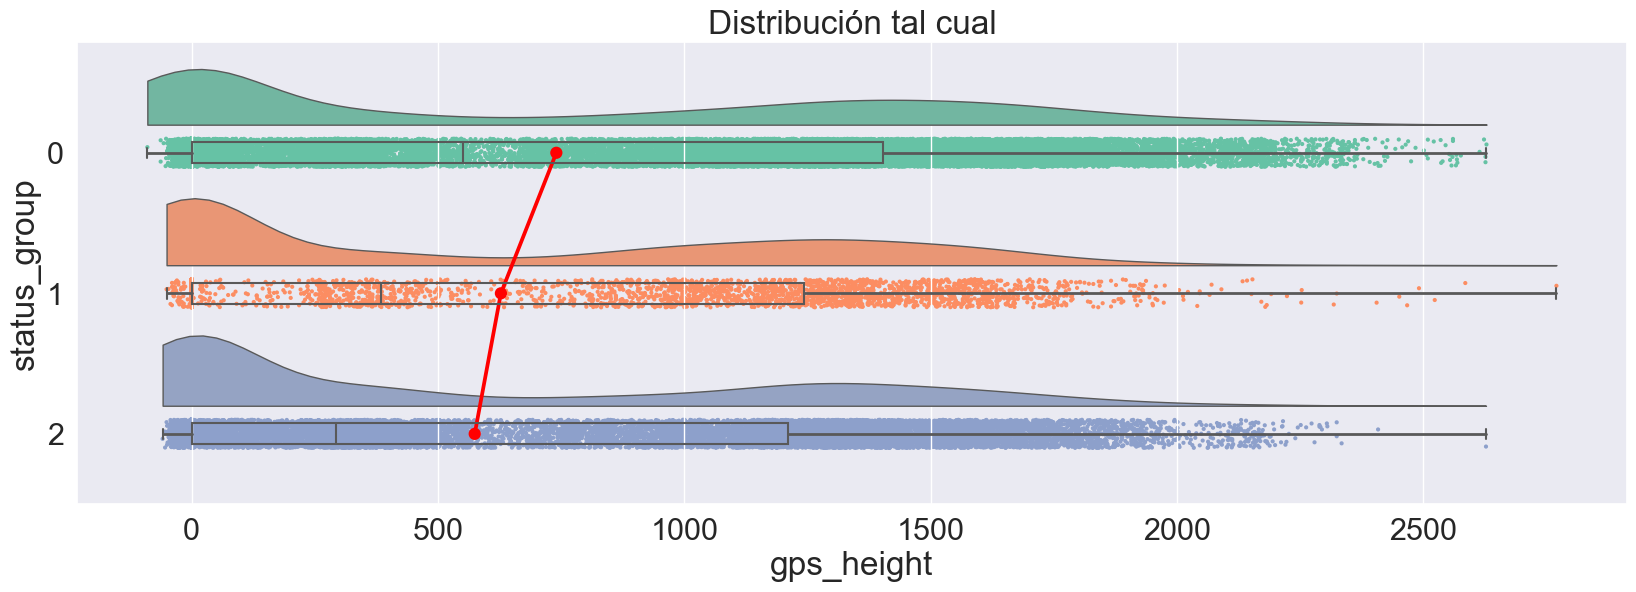

In [194]:
pt.RainCloud(x = "status_group", y = "gps_height", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

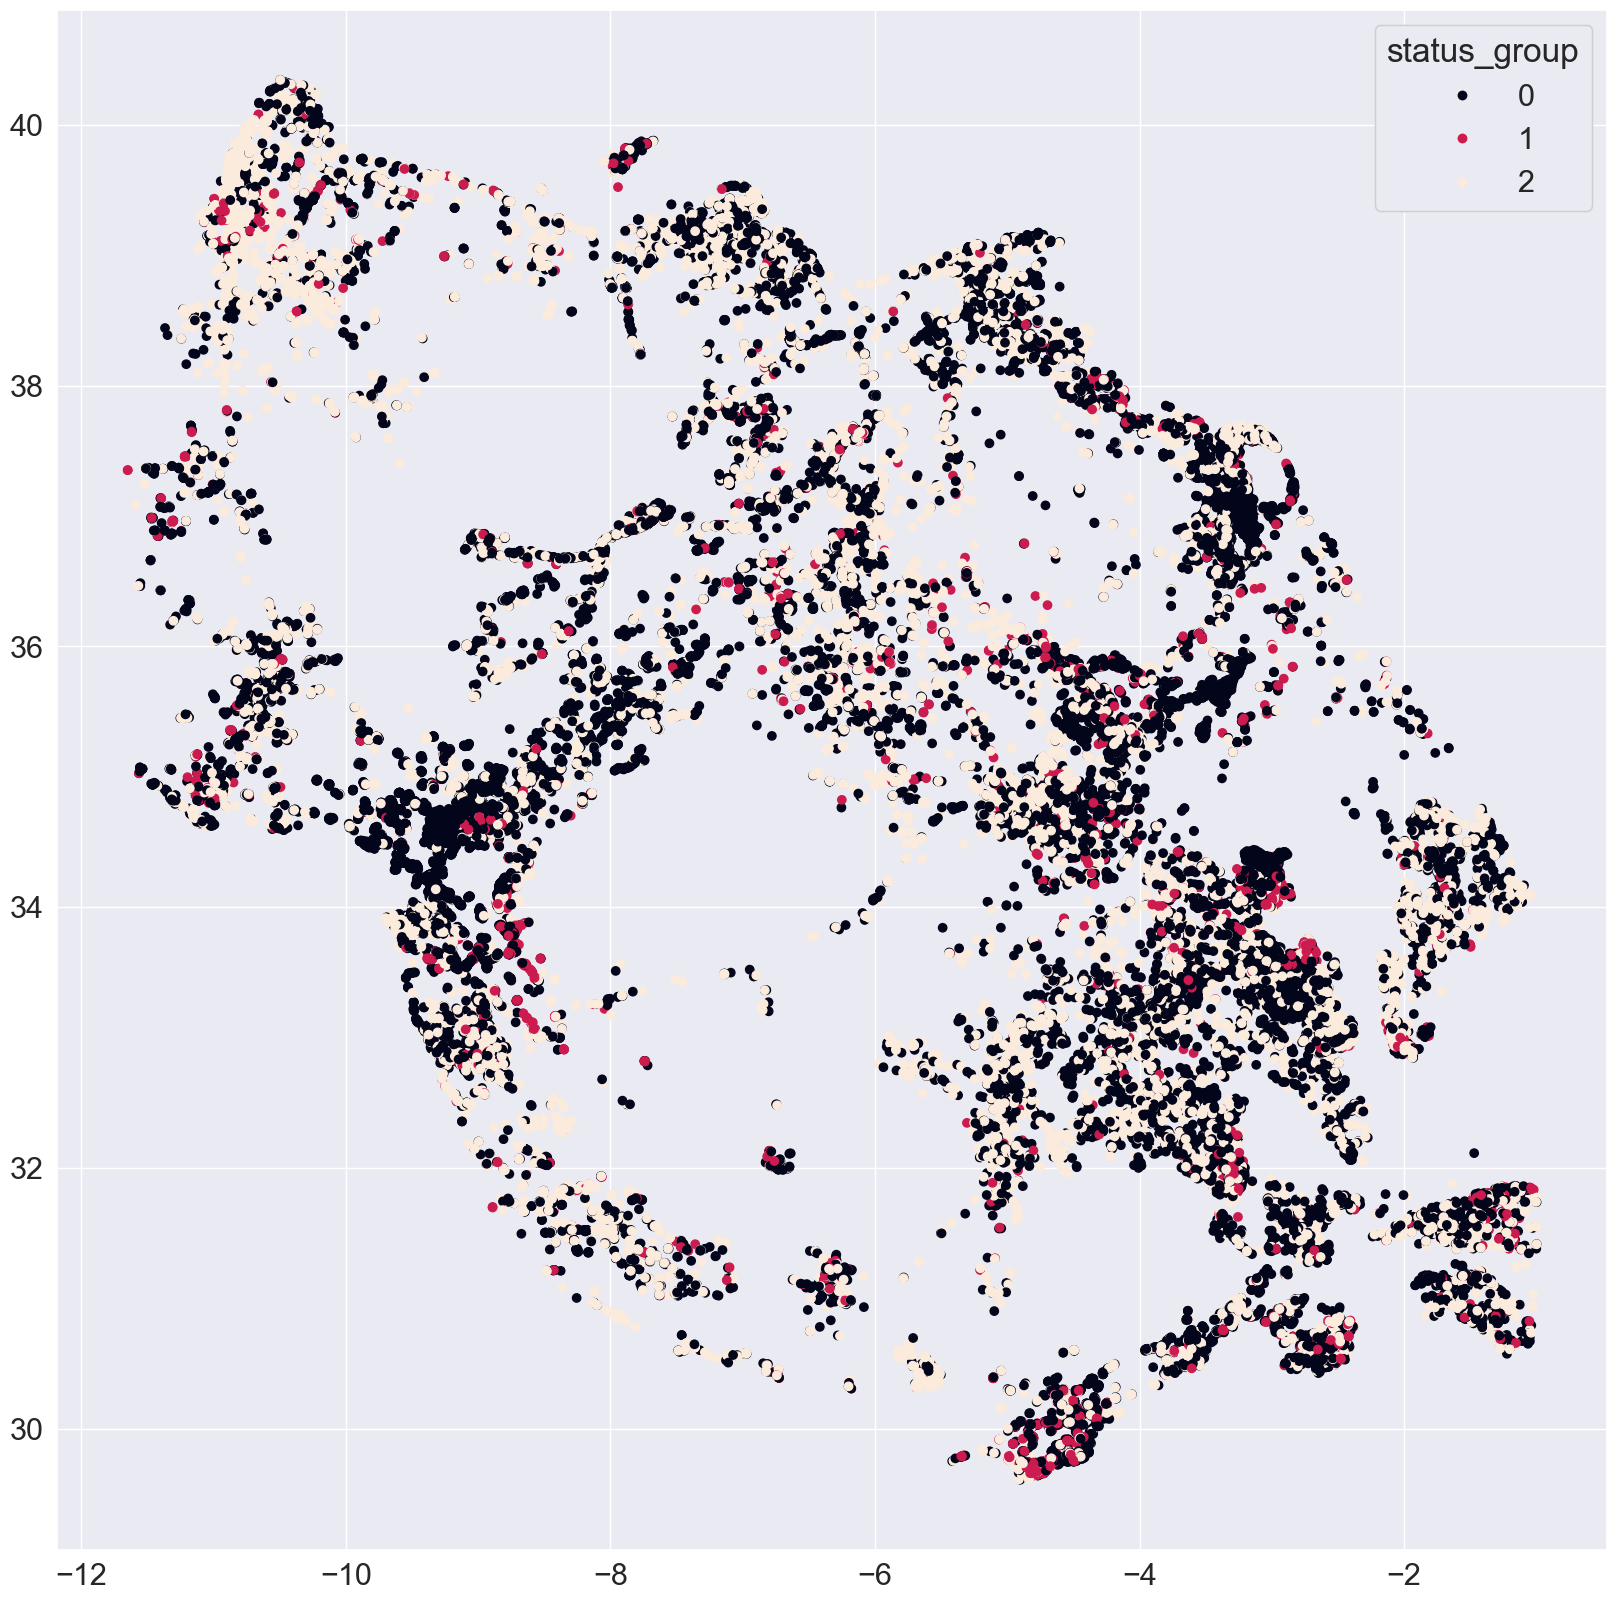

In [195]:
df_geo = df[["latitude","longitude","status_group"]].copy()
df_geo = df_geo[(df_geo["latitude"]!=0)&(df_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
scatter = ax.scatter(x=df_geo.latitude,y=df_geo.longitude,c=df_geo.status_group)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="status_group")
ax.add_artist(legend1)
plt.savefig('Graphs/Latitudlongitud.pdf')  


In [196]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [197]:
import joblib

In [198]:
df_geo.drop("status_group",axis=1,inplace=True)

### Lo que viene a continuación tarda demasiado tiempo y la primera vez lo hice (Jueves Santo) incluyendo status_group en el algoritmo, lo cual es por su puesto erróneo porque así no se pude transformar X_test

In [199]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

#Scaler = MinMaxScaler()
#df_geo.latitude = Scaler.fit_transform(df_geo.latitude.values.reshape(-1,1))
#df_geo.longitude = Scaler.fit_transform(df_geo.longitude.values.reshape(-1,1))

clustering = AgglomerativeClustering(linkage="ward", n_clusters=None,
                            distance_threshold = 0)
#clustering.fit(df_geo.to_numpy())

#joblib.dump(clustering, 'Models/LocationClustering.joblib')
clustering = joblib.load('Models/LocationClustering.joblib')

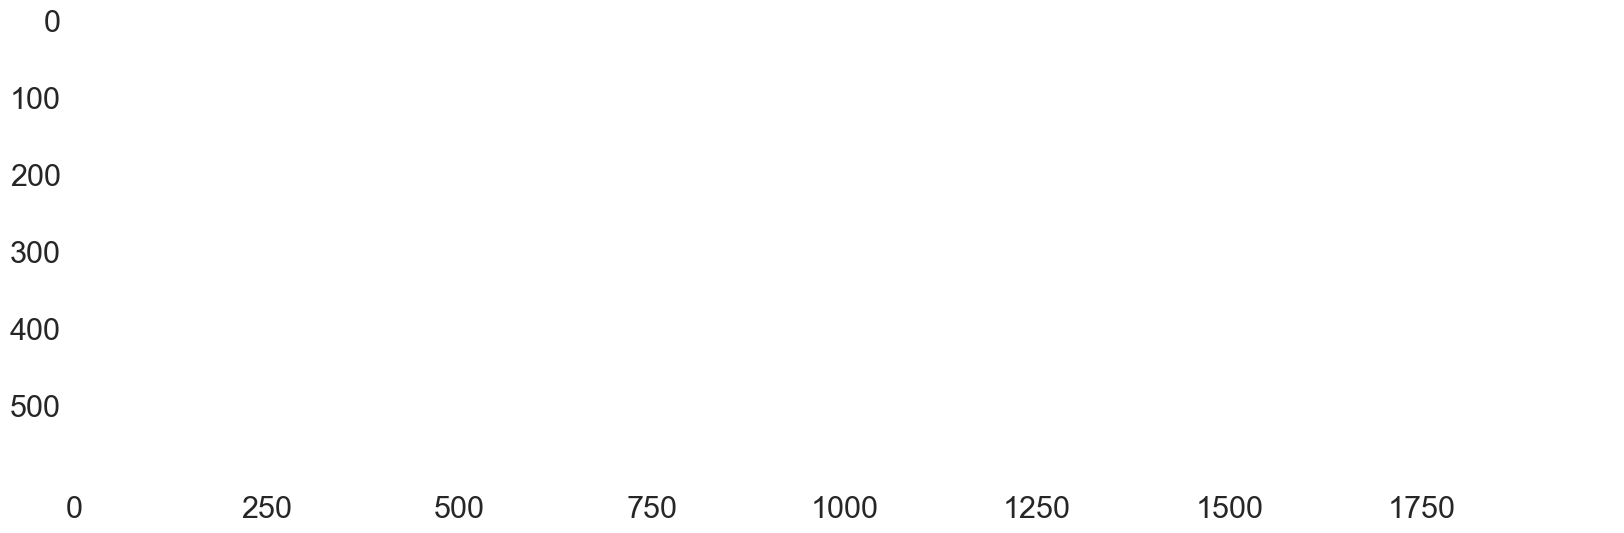

In [200]:
#jd.plot_dendogram(clustering)
#plt.savefig('Graphs/Dendograma_location.png')

Dendograma_location = plt.imread('Graphs/Dendograma_location.png')
plt.imshow(Dendograma_location)
plt.show()


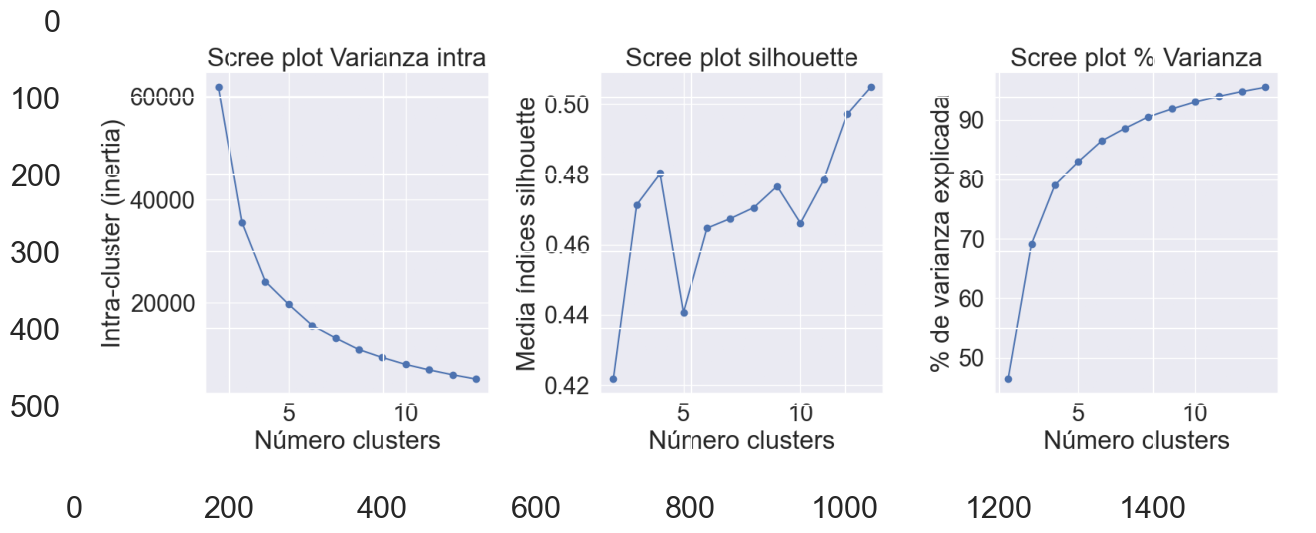

In [201]:
#jd.scree_plot_kmeans(df_geo,14)
#plt.savefig('Graphs/SkreePlot_location.png')
SkreePlot_location = plt.imread('Graphs/SkreePlot_location.png')
plt.imshow(SkreePlot_location)
plt.show()

In [202]:
#6-7 clusters parece ser la solución

In [203]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=7)
df_geo["location_cluster"] = clustering.fit_predict(df_geo)

In [204]:
X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
X_test["location_cluster"] = clustering.predict(X_test[["latitude","longitude"]].to_numpy())

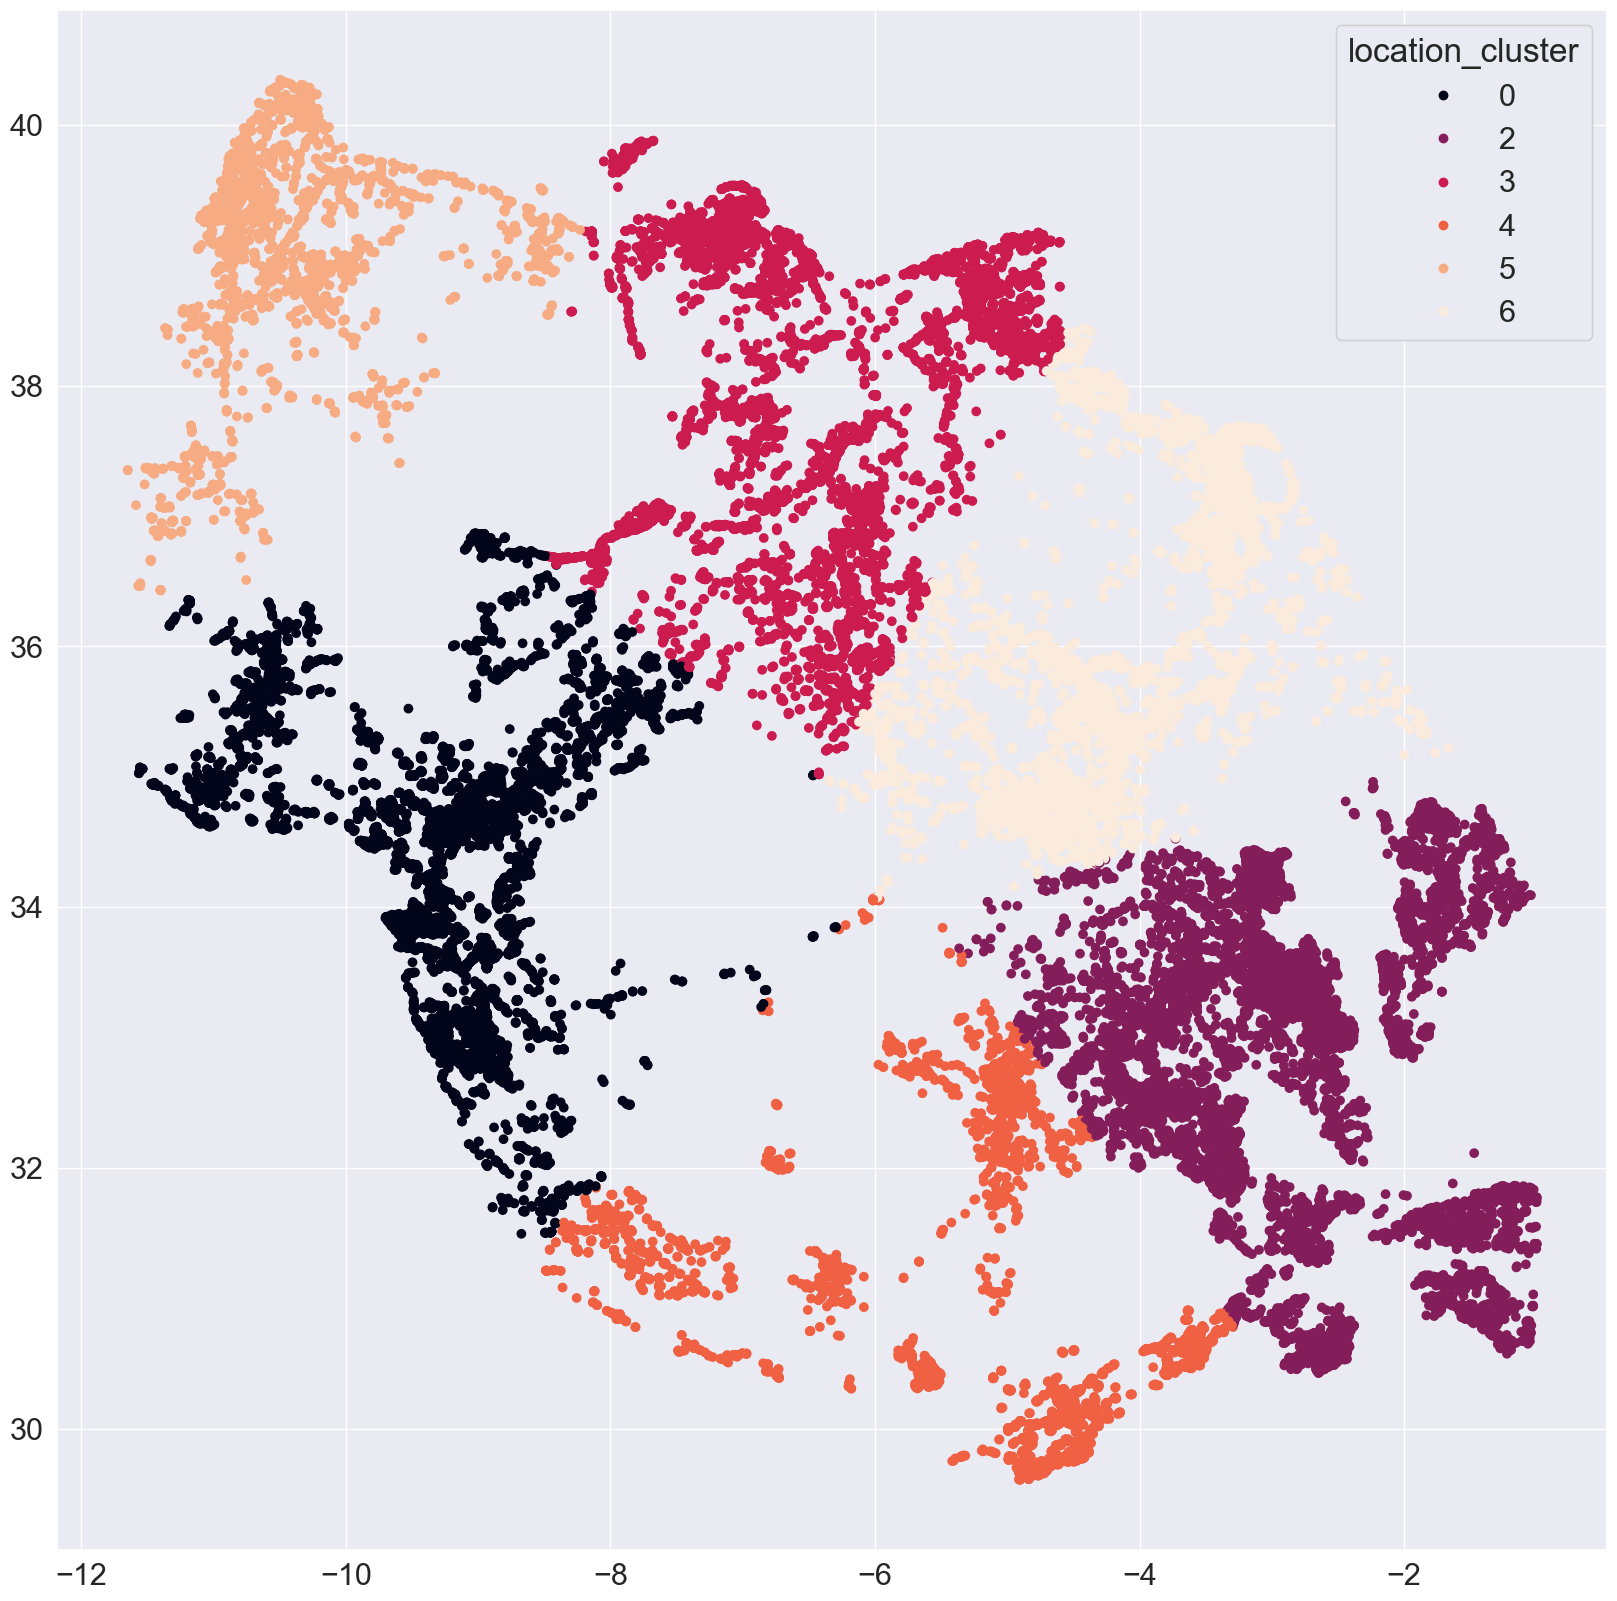

In [205]:
X_geo = X[["latitude","longitude","location_cluster"]].copy()
X_geo = X_geo[(X_geo["latitude"]!=0)&(X_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
scatter = ax.scatter(x=X_geo.latitude,y=X_geo.longitude,c=X_geo.location_cluster)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="location_cluster")
ax.add_artist(legend1)
plt.savefig('Graphs/Latitudlongitud7Clusters.pdf')  


In [206]:
X_geo.isna().sum()

latitude            0
longitude           0
location_cluster    0
dtype: int64

In [207]:
X.drop(["longitude","latitude"],axis=1,inplace=True)
X_test.drop(["longitude","latitude"],axis=1,inplace=True)

In [208]:
X.to_csv("Out/XReemplazoLongitudeLatitudeConClusters.csv")
X_test.to_csv("Out/X_testReemplazoLongitudeLatitudeConClusters.csv")

In [209]:
X.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

In [210]:
df_geo["location_cluster"]

0        3
1        2
2        4
3        5
4        0
        ..
59395    4
59396    3
59397    3
59398    1
59399    1
Name: location_cluster, Length: 57588, dtype: int32

In [211]:
#joblib.dump(clustering, 'Models/LocationClustering.joblib')
#LoadedClusterin = joblib.load('Models/LocationClustering.joblib')

### Num_private aunque es numérico parece que se comporta como una categórica, sólo tiene 65 valores únicos

In [212]:
#pt.RainCloud(x = "status_group", y = "num_private", data = df,width_viol = 1,orient = "h",pointplot=True)
#plt.title("Distribución tal cual")

# REGION CODE CATEGÓRICA O NUMÉRICA?

# REGION CODE CATEGÓRICA O NUMÉRICA?: PROBABLEMENTE AMBOS REGION Y DISTRICT CODE SE COMPORTEN COMO VARIABLES CATEGÓRICAS

Text(0.5, 1.0, 'Distribución tal cual')

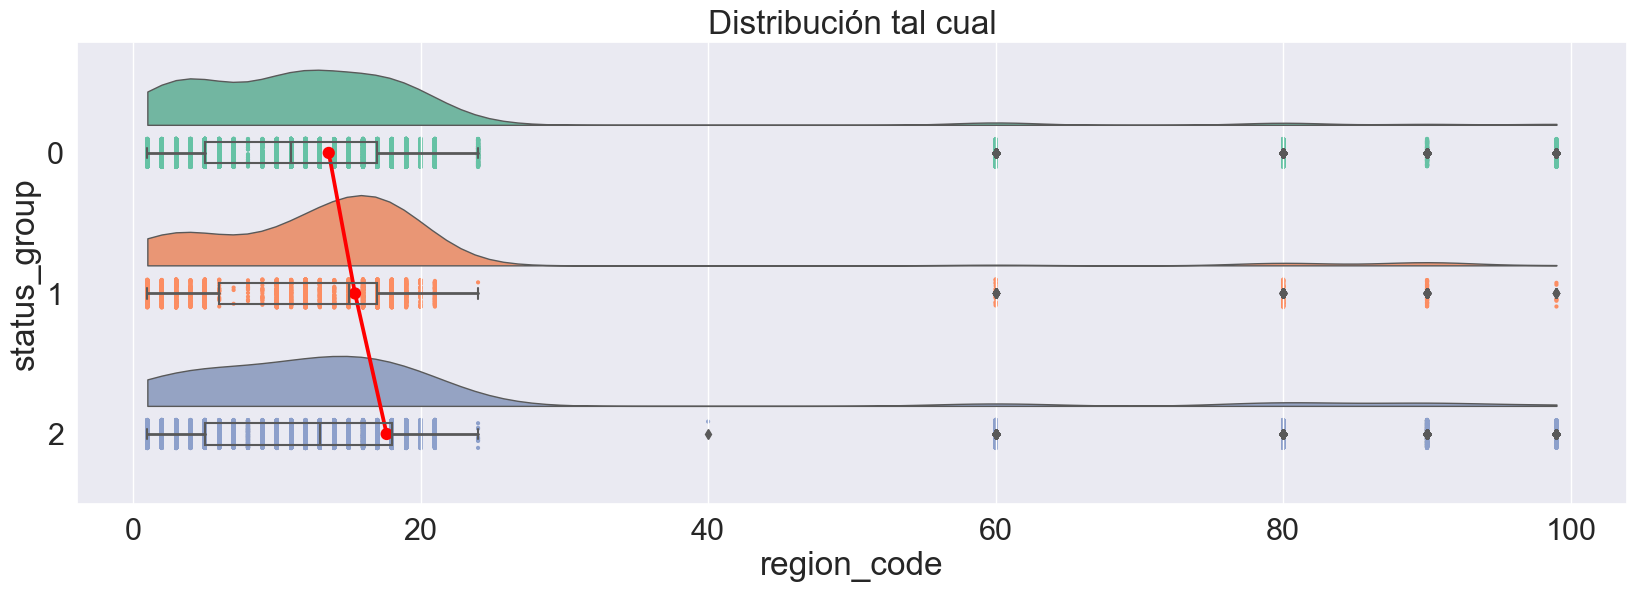

In [213]:
pt.RainCloud(x = "status_group", y = "region_code", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Distribución tal cual')

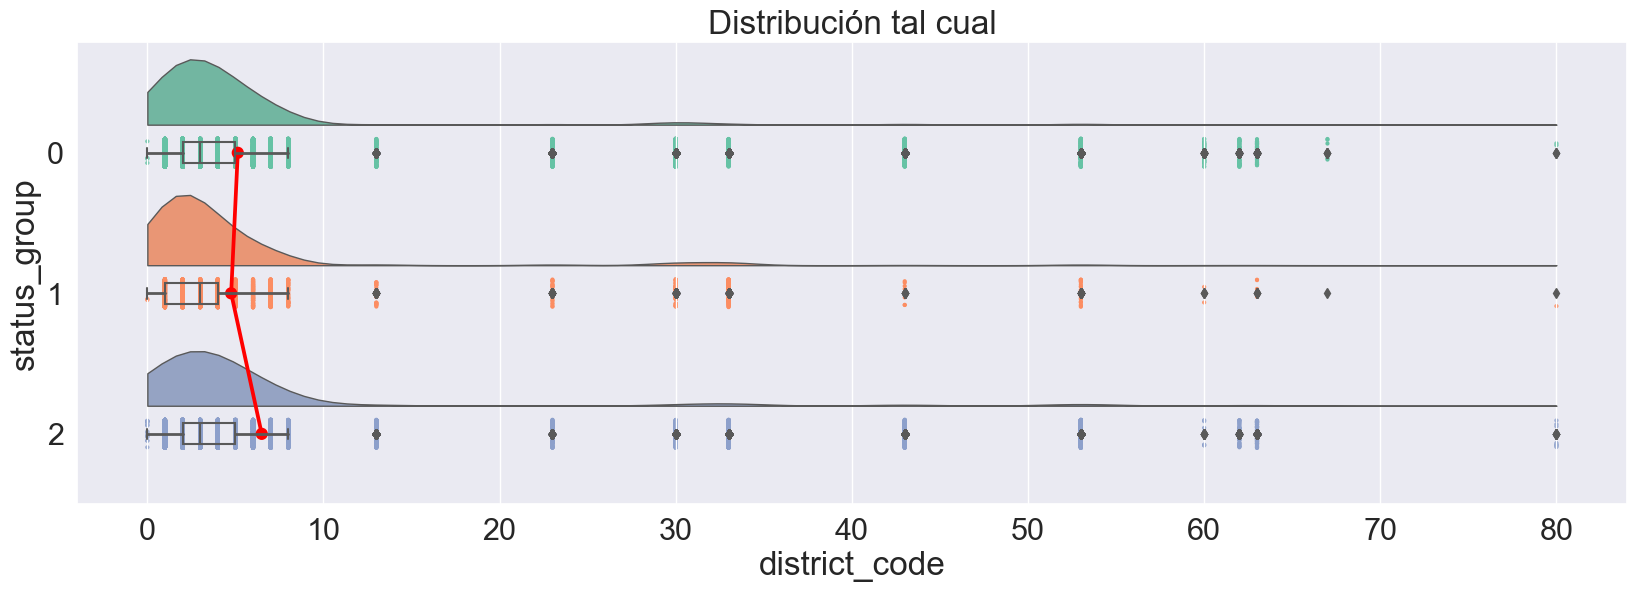

In [214]:
pt.RainCloud(x = "status_group", y = "district_code", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Distribución tal cual')

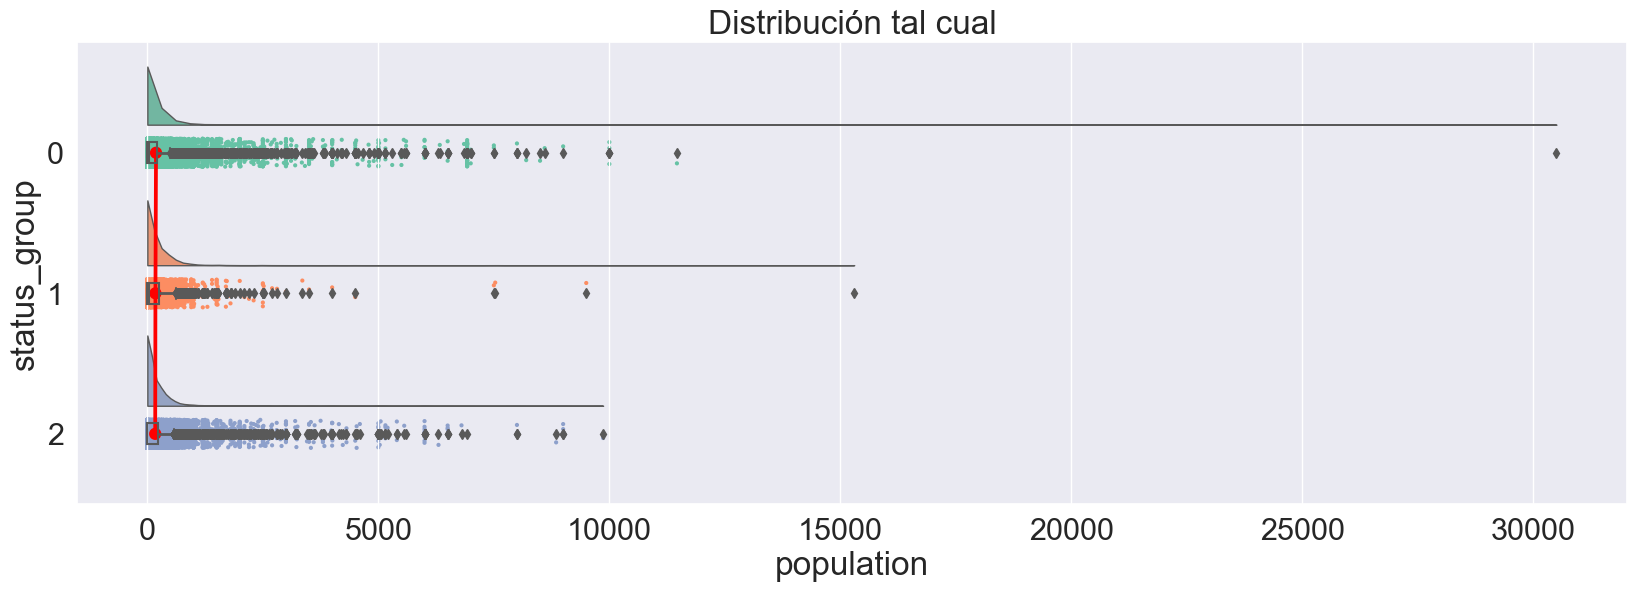

In [215]:
pt.RainCloud(x = "status_group", y = "population", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Distribución con valores menores a 5mil')

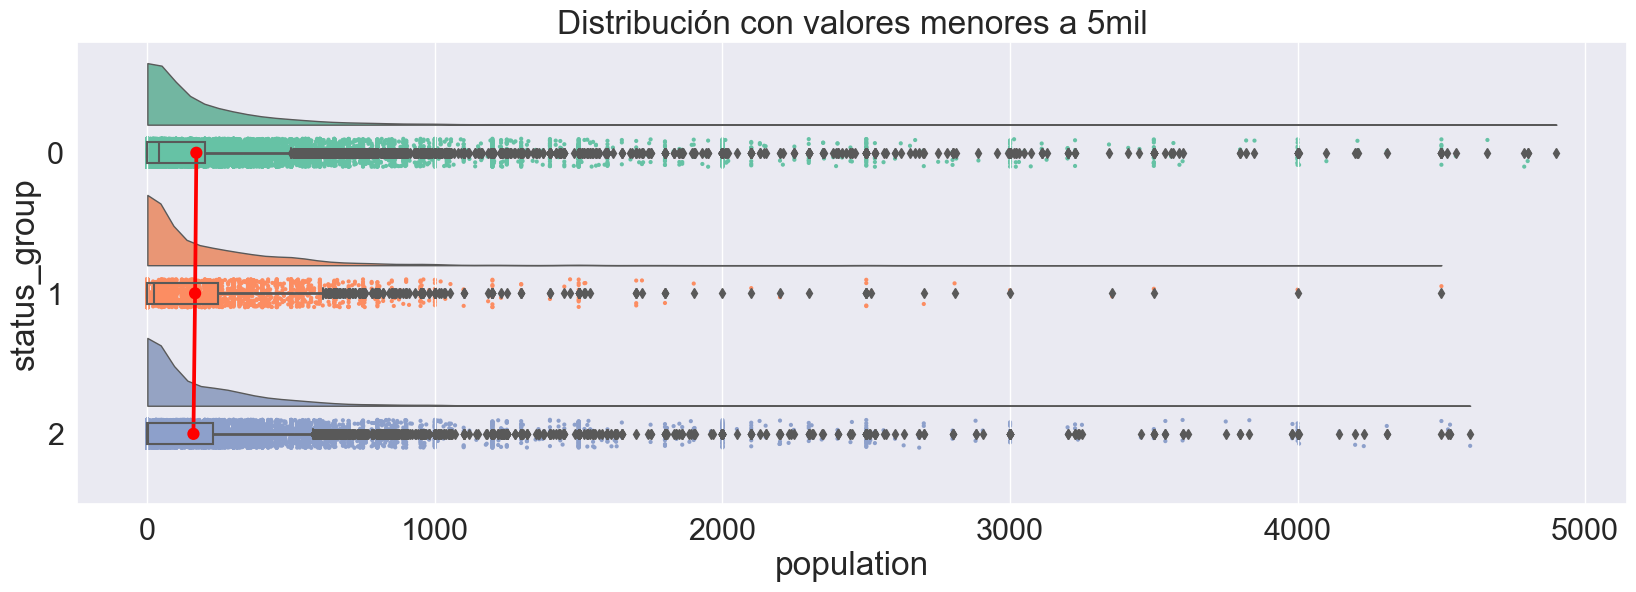

In [216]:
pt.RainCloud(x = "status_group", y = "population", data = df[df["population"]<5000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución con valores menores a 5mil")

Text(0.5, 1.0, 'Distribución con valores menores a mil')

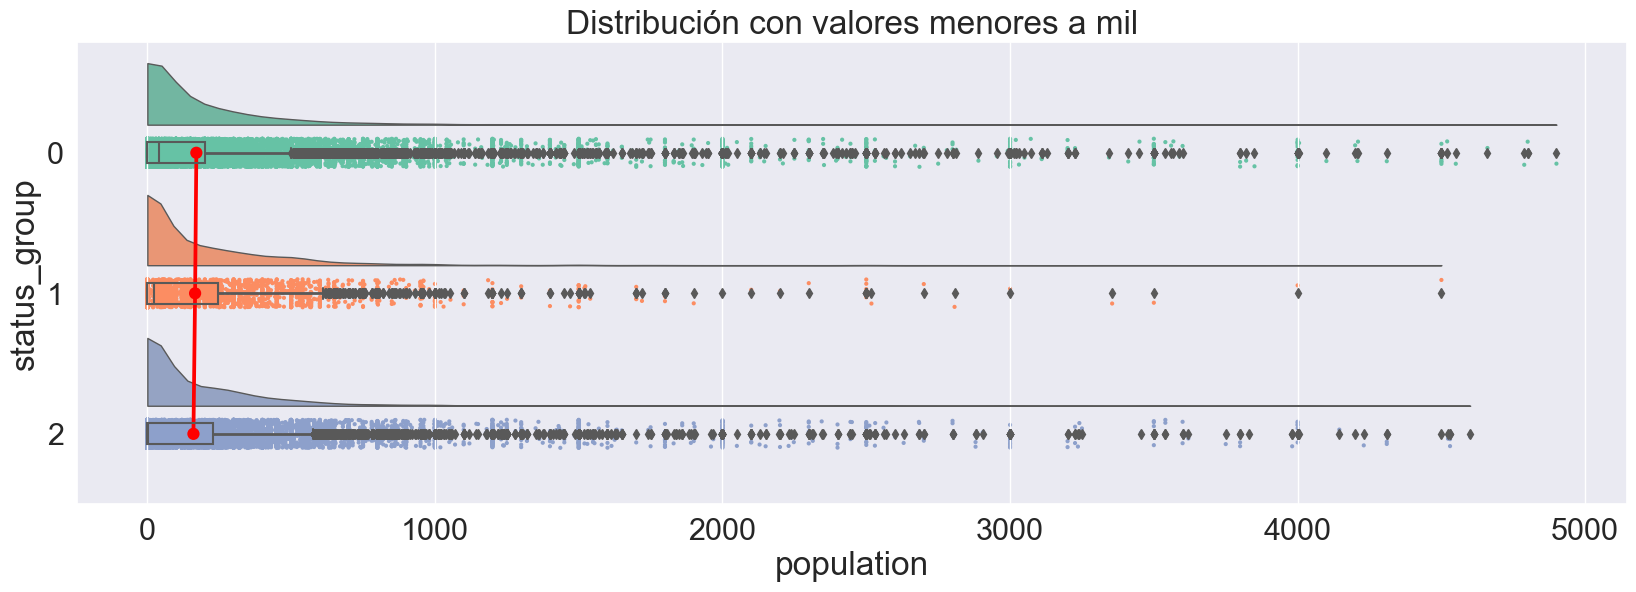

In [217]:
pt.RainCloud(x = "status_group", y = "population", data = df[df["population"]<5000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución con valores menores a mil")

<Axes: xlabel='construction_year'>

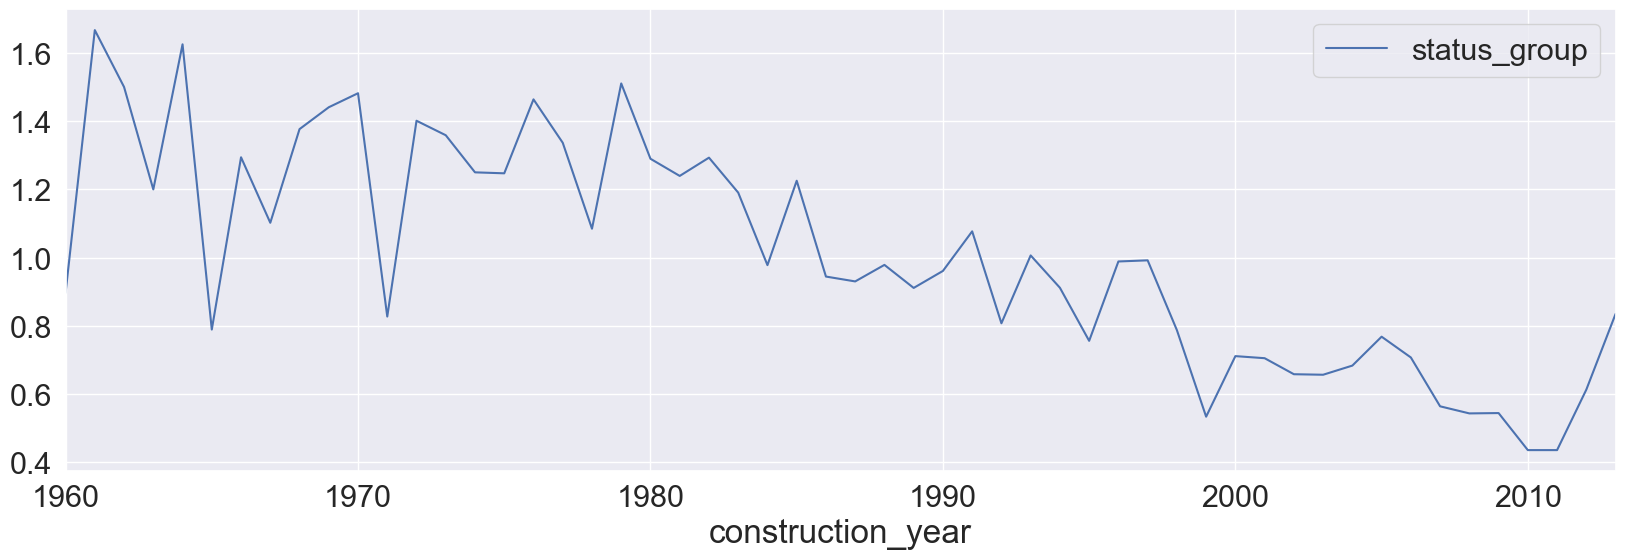

In [218]:
df_temp = df[["construction_year","status_group"]]

df_temp.construction_year = df_temp.construction_year.apply(lambda x: x if x!= 0 else 1960)
df_temp.construction_year = pd.to_datetime(df_temp.construction_year, format='%Y')#.dt.year
df_temp.groupby("construction_year").mean().plot()

In [219]:
df.construction_year

0        1999
1        2010
2        2009
3        1986
4           0
         ... 
59395    1999
59396    1996
59397       0
59398       0
59399    2002
Name: construction_year, Length: 59400, dtype: int64

In [220]:
df.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group', 'random', 'random2'],
      dtype='object')

In [221]:
df.select_dtypes(exclude=np.number).columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

# AHORA LAS VARIABLES CATEGÓRICAS: empezaré usando optbinning


In [222]:
#optb = MulticlassOptimalBinning(max_n_bins=None,max_pvalue=0.10).fit(df.funder,df.status_group)
#ValueError: x array after removing special codes and missing values must be numerical.


## Al parecer OptBinning sólo tiene implementación para hacer agrupaciones de variables categóricas cuando el target es binario :(

In [223]:
df.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group', 'random', 'random2'],
      dtype='object')

In [224]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [225]:
y
y = le.fit_transform(y.status_group)

In [226]:
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
preprocessing = ColumnTransformer([
    ('target_enc', TargetEncoder(), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X_transformed = preprocessing.fit_transform(X,y=y)
transformed_columns = preprocessing.get_feature_names_out()

# Create DataFrame from transformed data
X_transformed = pd.DataFrame(data=X_transformed, columns=transformed_columns)
X_transformed

,target_enc__date_recorded,target_enc__funder,target_enc__installer,target_enc__wpt_name,target_enc__basin,target_enc__subvillage,target_enc__region,target_enc__lga,target_enc__ward,target_enc__public_meeting,...,target_enc__waterpoint_type_group,scaler__amount_tsh,scaler__gps_height,scaler__num_private,scaler__region_code,scaler__district_code,scaler__population,scaler__construction_year,scaler__location_cluster,remainder__id
0,0.665385,0.323636,0.712844,0.502386,0.643461,0.740705,0.412354,0.430851,0.765313,0.813295,...,0.763032,1.895665,1.041252,-0.038749,-0.244325,-0.065370,-0.150399,0.733857,-1.362520,69572.0
1,0.681820,0.393857,0.377101,0.869880,0.908177,0.687712,1.069578,0.777933,0.747053,0.946611,...,0.763032,-0.105970,1.054237,-0.038749,0.267409,-0.376781,0.212290,0.745416,-0.418026,8776.0
2,0.790614,0.646454,0.558824,0.711231,0.744855,0.996016,0.692356,0.821429,0.668727,0.813295,...,0.763032,-0.097630,0.025541,-0.038749,0.324269,-0.169174,0.148660,0.744365,1.470962,34310.0
3,1.162234,0.771050,0.887387,0.991936,1.184064,0.933789,1.321387,1.468354,1.443561,0.813295,...,0.763032,-0.105970,-0.584751,-0.038749,4.247564,5.955245,-0.258570,0.720196,0.998715,67743.0
4,0.991667,0.731719,0.844444,0.935355,0.908177,0.721842,0.866707,0.880674,0.664150,0.813295,...,0.763032,-0.105970,-0.964200,-0.038749,0.153691,-0.480585,-0.381587,-1.366788,-0.418026,19728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.821622,0.234426,0.234426,0.731719,0.744855,0.699862,0.720712,0.252800,0.051778,0.813295,...,0.763032,-0.102634,0.781553,-0.038749,-0.699200,-0.065370,-0.116463,0.733857,1.470962,60739.0
59396,0.687712,0.357963,0.523589,0.731719,0.674398,0.543101,0.412354,0.358769,0.612218,0.813295,...,0.763032,1.461977,0.784439,-0.038749,-0.244325,-0.169174,-0.262812,0.730704,-1.362520,27263.0
59397,1.025478,0.789937,0.785226,0.926299,0.674398,0.721842,0.891571,0.792332,1.079280,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.187465,0.142237,-0.381587,-1.366788,-1.362520,37057.0
59398,0.759146,0.711231,0.833653,0.731719,0.674398,1.011092,0.988187,1.086455,0.964930,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.812918,-0.169174,-0.381587,-1.366788,0.054221,31282.0


In [227]:
X_transformed

,target_enc__date_recorded,target_enc__funder,target_enc__installer,target_enc__wpt_name,target_enc__basin,target_enc__subvillage,target_enc__region,target_enc__lga,target_enc__ward,target_enc__public_meeting,...,target_enc__waterpoint_type_group,scaler__amount_tsh,scaler__gps_height,scaler__num_private,scaler__region_code,scaler__district_code,scaler__population,scaler__construction_year,scaler__location_cluster,remainder__id
0,0.665385,0.323636,0.712844,0.502386,0.643461,0.740705,0.412354,0.430851,0.765313,0.813295,...,0.763032,1.895665,1.041252,-0.038749,-0.244325,-0.065370,-0.150399,0.733857,-1.362520,69572.0
1,0.681820,0.393857,0.377101,0.869880,0.908177,0.687712,1.069578,0.777933,0.747053,0.946611,...,0.763032,-0.105970,1.054237,-0.038749,0.267409,-0.376781,0.212290,0.745416,-0.418026,8776.0
2,0.790614,0.646454,0.558824,0.711231,0.744855,0.996016,0.692356,0.821429,0.668727,0.813295,...,0.763032,-0.097630,0.025541,-0.038749,0.324269,-0.169174,0.148660,0.744365,1.470962,34310.0
3,1.162234,0.771050,0.887387,0.991936,1.184064,0.933789,1.321387,1.468354,1.443561,0.813295,...,0.763032,-0.105970,-0.584751,-0.038749,4.247564,5.955245,-0.258570,0.720196,0.998715,67743.0
4,0.991667,0.731719,0.844444,0.935355,0.908177,0.721842,0.866707,0.880674,0.664150,0.813295,...,0.763032,-0.105970,-0.964200,-0.038749,0.153691,-0.480585,-0.381587,-1.366788,-0.418026,19728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.821622,0.234426,0.234426,0.731719,0.744855,0.699862,0.720712,0.252800,0.051778,0.813295,...,0.763032,-0.102634,0.781553,-0.038749,-0.699200,-0.065370,-0.116463,0.733857,1.470962,60739.0
59396,0.687712,0.357963,0.523589,0.731719,0.674398,0.543101,0.412354,0.358769,0.612218,0.813295,...,0.763032,1.461977,0.784439,-0.038749,-0.244325,-0.169174,-0.262812,0.730704,-1.362520,27263.0
59397,1.025478,0.789937,0.785226,0.926299,0.674398,0.721842,0.891571,0.792332,1.079280,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.187465,0.142237,-0.381587,-1.366788,-1.362520,37057.0
59398,0.759146,0.711231,0.833653,0.731719,0.674398,1.011092,0.988187,1.086455,0.964930,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.812918,-0.169174,-0.381587,-1.366788,0.054221,31282.0


In [228]:
rf = RandomForestClassifier()
rf.fit(X_transformed,y)

RandomForestClassifier()

In [229]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X_transformed,y)

In [230]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


In [231]:
r = 23 #Fijamos la aleatoriedad

#Diccionario con todos los modelos
Modelos = {
    'Reg_Log': LogisticRegression(random_state=r),
    'SGD': SGDClassifier(random_state=r),
    'Perceptron': Perceptron(random_state=r),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM_rbf': SVC(random_state=r),
    #'SVM_poly': SVC(kernel='poly', random_state=r),
    #'SVM_sigmoid': SVC(kernel='sigmoid', random_state=r),
    'SVM_linear': LinearSVC(random_state=r),
    'KNeighbors': KNeighborsClassifier(),
    'Gauss_Naive': GaussianNB(),
    'Tree': DecisionTreeClassifier(random_state=r),
    'RF': RandomForestClassifier(random_state=r),
    'Extra_Tree': ExtraTreesClassifier(random_state=r),
    'AdaBoost': AdaBoostClassifier(random_state=r),
    'GradBoost': GradientBoostingClassifier(random_state=r),
    'GradBoost_NB': GradientBoostingClassifier(random_state=r,init=GaussianNB()),
    'GradBoost_LogReg': GradientBoostingClassifier(random_state=r,init=LogisticRegression()),
    'MLP': MLPClassifier(random_state=r),
}

#Dataframe de métricas
metrics2 = pd.DataFrame(columns=['Modelo','Accuracy','Balanced_Accuracy'])

#Entrenamos y evaluamos cada modelo mediante validación cruzada estratificada (por defecto) con 10 divisiones
"""
for nom, mod in Modelos.items():
    print(nom)
    results = cross_validate(mod, X_transformed, y, cv=5, scoring=(['accuracy','balanced_accuracy']))
   
    #Añadimos al dataframe de métricas el nombre y la media de cada métrica en las 10 evaluaciones para cada modelo
    metrics2 = pd.concat([metrics2, pd.DataFrame([{
        'Modelo': nom,
        'Accuracy': results['test_accuracy'].mean(),
        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()
    }])], ignore_index=True)
"""


"\nfor nom, mod in Modelos.items():\n    print(nom)\n    results = cross_validate(mod, X_transformed, y, cv=5, scoring=(['accuracy','balanced_accuracy']))\n   \n    #Añadimos al dataframe de métricas el nombre y la media de cada métrica en las 10 evaluaciones para cada modelo\n    metrics2 = pd.concat([metrics2, pd.DataFrame([{\n        'Modelo': nom,\n        'Accuracy': results['test_accuracy'].mean(),\n        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()\n    }])], ignore_index=True)\n"

## Vemos muchas métricas, pero a efectos de la competencia sólo nos interesa el accuracy

In [232]:
#metrics2 = metrics2[["Modelo","Accuracy","Balanced_Accuracy"]].sort_values(by="Accuracy",ascending=False)
#metrics2.to_pickle('DataFrames/1eraBateriaModelos.pkl')
metrics2 = pd.read_pickle('DataFrames/1eraBateriaModelos.pkl')
metrics2

,Modelo,Accuracy,Balanced_Accuracy
13,GradBoost,0.929192,0.855513
15,GradBoost_LogReg,0.927374,0.849963
10,RF,0.925522,0.850585
12,AdaBoost,0.912088,0.812595
11,Extra_Tree,0.899343,0.788877
9,Tree,0.895337,0.840311
3,LDA,0.839714,0.660664
8,Gauss_Naive,0.701448,0.481003
4,QDA,0.684714,0.669010
6,SVM_linear,0.620101,0.461617


#### RF da un accuracy de 0.92, pero en el test oficial el score es menor, eso se debe probablemente a que el target está desbalanceado y en el test aparece frecuentemente una de las etiquetas desbalanceadas

In [233]:
drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
le = LabelEncoder()
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
y = le.fit_transform(y.status_group)
X_test = pd.read_csv("In/Test_set_values.csv")

X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)


for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")

In [234]:
metrics = pd.DataFrame(columns=['Clusters','Accuracy','Balanced_Accuracy'])
for num_clusts in ["cont",7,9,10,16,20]:
    print(num_clusts)

    if num_clusts != "cont":
        clustering = KMeans(n_clusters=num_clusts)
        X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())

    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    num_cols.remove("id")
    if num_clusts != "cont":
        num_cols.remove("latitude")
        num_cols.remove("longitude")
    preprocessing = ColumnTransformer([
        ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
        ('scaler', StandardScaler(), num_cols),  
    ],
    remainder = "passthrough",
    )
    if num_clusts != "cont":
        
        X_transformed = preprocessing.fit_transform(X.drop(["latitude","longitude"],axis=1,inplace=False),y=y)
    else:
        X_transformed = preprocessing.fit_transform(X,y=y)


    transformed_columns = preprocessing.get_feature_names_out()

    # Create DataFrame from transformed data
    X_transformed = pd.DataFrame(data=X_transformed, columns=transformed_columns)
    gradBoost = GradientBoostingClassifier(random_state=23)

    """
    results = cross_validate(gradBoost, X_transformed, y, cv=4, scoring=(['accuracy','balanced_accuracy']),n_jobs=-1)
    metrics = pd.concat([metrics, pd.DataFrame([{
        'Clusters': f"Con {str(num_clusts)} clusters",
        'Accuracy': results['test_accuracy'].mean(),
        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()
    }])], ignore_index=True)
    """

cont
7
9
10
16
20


In [235]:
#metrics = metrics.sort_values(by="Accuracy",ascending=False)
#metrics.to_pickle('DataFrames/Num_ClustsGradBoost_BateriaModelos.pkl')
metrics = pd.read_pickle('DataFrames/Num_ClustsGradBoost_BateriaModelos.pkl')
metrics

,Clusters,Accuracy,Balanced_Accuracy
0,Con cont clusters,0.753384,0.560199
5,Con 20 clusters,0.752710,0.553575
4,Con 16 clusters,0.752559,0.554882
3,Con 10 clusters,0.752475,0.555604
2,Con 9 clusters,0.752374,0.557475
1,Con 7 clusters,0.751667,0.553283


## EL trabajo de limpieza que había hecho se me borró por un error de subir a github sin haber guardado correctamente este archivo, al hacer git pull se fue toda la limpieza

In [236]:
# El resultado de la limpieza igualmente quedó guardado en el otro archivo en esta lista.


## La limpieza comienza con un campo de valor único.

In [237]:
#drop recorded_by
[(x,y) for (x,y) in df.nunique().items() if y==1]

[('recorded_by', 1)]

### Limpio el campo en formato fecha

In [238]:
df.date_recorded = df.date_recorded.astype("O")
df.date_recorded = pd.to_datetime(df.date_recorded)
df.date_recorded.max()
df['date_recorded'] = (df.date_recorded.max() -df.date_recorded).dt.days
df['date_recorded']

0         995
1         272
2         281
3         309
4         874
         ... 
59395     214
59396     941
59397     967
59398    1001
59399     986
Name: date_recorded, Length: 59400, dtype: int64

# Tiene unos cuantos aparentes outliers

Asociación con la objetivo: 0.03466752163433419


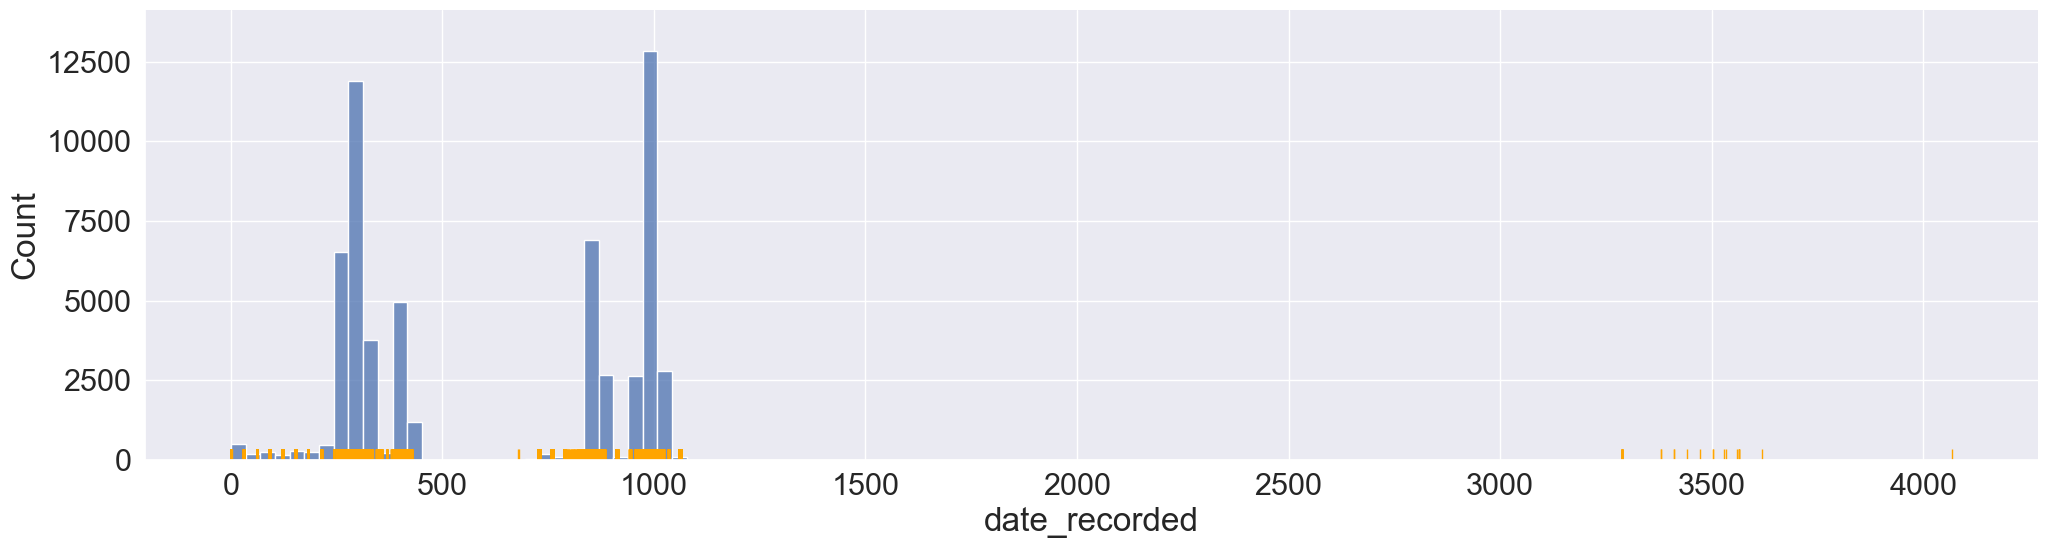

<Axes: xlabel='date_recorded'>

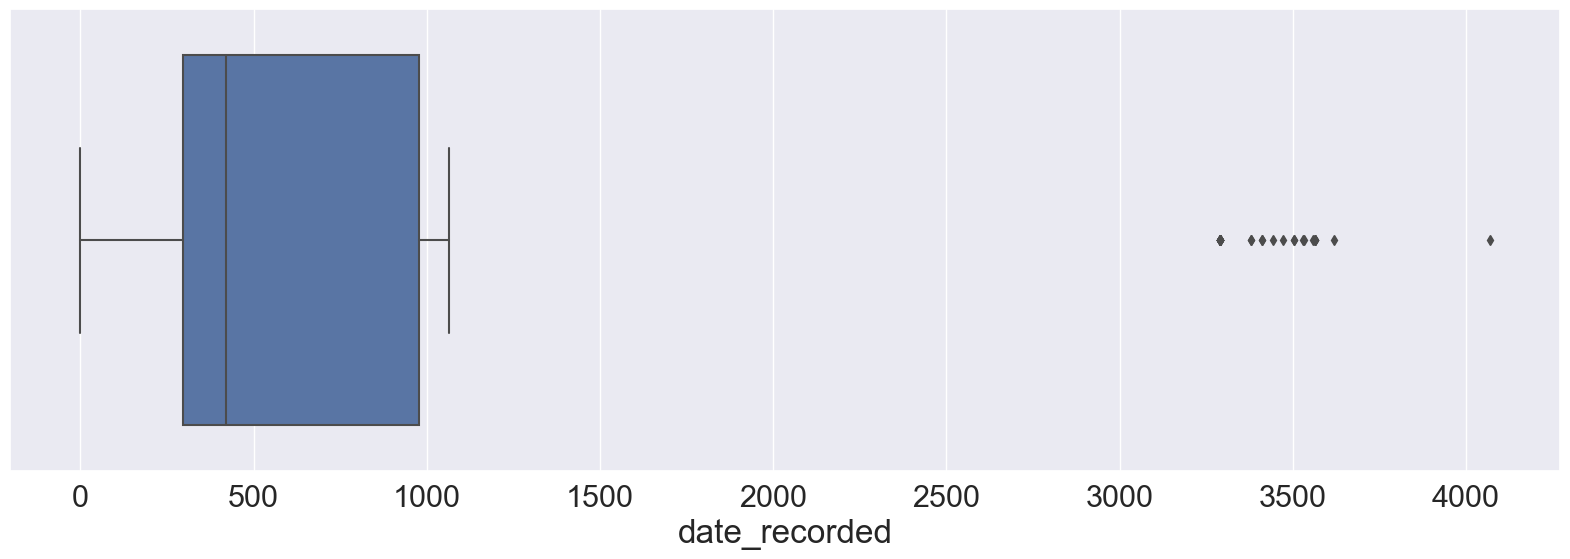

In [239]:
cramer = jd.cramers_v(df['date_recorded'],df["status_group"])
print(f"Asociación con la objetivo: {cramer}")
sns.displot(df['date_recorded'], height=6, aspect=3.5,kind='hist',rug=True, rug_kws={"color": "orange"})
plt.show()
sns.boxplot(df['date_recorded'])


### La limpieza sigue buscando las características con datos missing


In [240]:
[(x,y) for (x,y) in df.isna().sum().items() if y>0]

[('funder', 3637),
 ('installer', 3655),
 ('wpt_name', 2),
 ('subvillage', 371),
 ('public_meeting', 3334),
 ('scheme_management', 3878),
 ('scheme_name', 28810),
 ('permit', 3056)]

## Funder e Installer

In [241]:
df[["funder","installer"]]
jd.cramers_v(df.funder,df.installer)
 # Son muy parecidos entre ellos, en lo que se borró había decidido hacerle drop al que tenía menor asociación cramer con la objetivo, pero en verdad, sabiendo que lo que mejor predice X_test es un random forest y que el 
# random forest no tiene problemas con la multicolinearidad, no hay necesidad de hacerle drop a ninguno.

# Justifico mi uso del IterativeImputer con la fuerte asociación de ambos con el resto del DataFrame
cramer_dict = {}
for i in df.columns:
    cramer= jd.cramers_v(df.funder,df[i])
    cramer_dict[i] = cramer
print("Top asociaciones del df con funder:")
print(pd.Series(cramer_dict).sort_values(ascending=False).head(10))
print()
cramer_dict = {}
for i in df.columns:
    cramer= jd.cramers_v(df.installer,df[i])
    cramer_dict[i] = cramer
print("Top asociaciones del df con installer:")
print(pd.Series(cramer_dict).sort_values(ascending=False).head(10))


Top asociaciones del df con funder:
funder               1.000000
wpt_name             0.802221
installer            0.765529
region               0.725661
construction_year    0.710536
latitude             0.702642
region_code          0.696729
scheme_name          0.686300
basin                0.677181
district_code        0.660757
dtype: float64

Top asociaciones del df con installer:
installer        1.000000
wpt_name         0.805724
region_code      0.779618
funder           0.765529
region           0.733605
district_code    0.732219
latitude         0.683255
lga              0.681476
scheme_name      0.676530
basin            0.676127
dtype: float64


In [242]:
def asociaciones_df_var(data,var,n=10,remove= ["id","num_private","recorded_by","random","random2"]):
    cramer_dict = {}
    columnas = data.columns.tolist()
    columnas.remove(var)
    for i in remove:
        columnas.remove(i)
    for col in columnas:
        cramer= jd.cramers_v(data[var],df[col])
        cramer_dict[col] = cramer
    print(f"Top {n} asociaciones del df con {var}:")
    print(pd.Series(cramer_dict).sort_values(ascending=False).head(n))


In [243]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'random', 'random2'],
      dtype='object')

In [244]:
drop_list  = ["scheme_name","management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]#saco funder de la lista que no me funcnó tan mal y rectifico mi desciciçon de imputa con el immputador iterativo.

## wpt_name tiene dos missings, no tendrá mucho efecto en el resultado la técnica que utilice

## subvillage

Value counts:
[('Mwadudu', 1), ('Mwamagangati', 1), ('Mwaya B', 1), ('Mwandenga', 1), ('Mwadugulu', 1), ('Wimbwa', 1), ('Mwaduguru', 1), ('Zege', 1), ('Mwandunguku', 1), ('Mwabuliochi', 1), ('Mwandera', 1), ('Viwanjastini', 1), ('Mwanduu', 1), ('Mwadanga', 1), ('Mwasiti', 1), ('Mwabulandi', 1), ('Mwandutu', 1), ('Mwabukwimba', 1), ('Mwaya A', 1), ('Uwiga', 1), ('Mwanduominzi', 1), ('Mwadele', 1), ('Walisa', 1), ('Mwadole', 1), ('Wni Kati', 1), ('Mwamashele', 1), ('Zimbabwe', 1), ('Mzinga B', 1), ('Mwanza Ya Madaso', 1), ('Mwanya Shuleni', 1), ('Uwinwi', 1), ('Mwadegeleki', 1), ('Wingi', 1), ('Mwanyachiza', 1), ('Mwamagarani', 1), ('Mwasuta', 1), ('Mwabulilo', 1), ('Mwamasha', 1), ('Mwabunuri', 1), ('Mwanza Mangombe', 1), ('Mwandili A', 1), ('Mwandomo', 1), ('Mwasomi', 1), ('Mwandito', 1), ('Vikuruti', 1), ('Mzizini', 1), ('Mwamadilana', 1), ('Mwamasele', 1), ('Mwamachibya', 1), ('Mzungu B', 1), ('Mwamabulo', 1), ('Uwaya', 1), ('Mzungu Wa Sala', 1), ('Zelui', 1), ('Mwayole', 1), ('Viweg

subvillage
Madukani          508
Shuleni           506
Majengo           502
Kati              373
Mtakuja           262
                 ... 
Gwashyi             2
Kilaweni Chini      2
Kisangari           2
Nyawami             2
Kiloa               2
Name: count, Length: 9863, dtype: int64

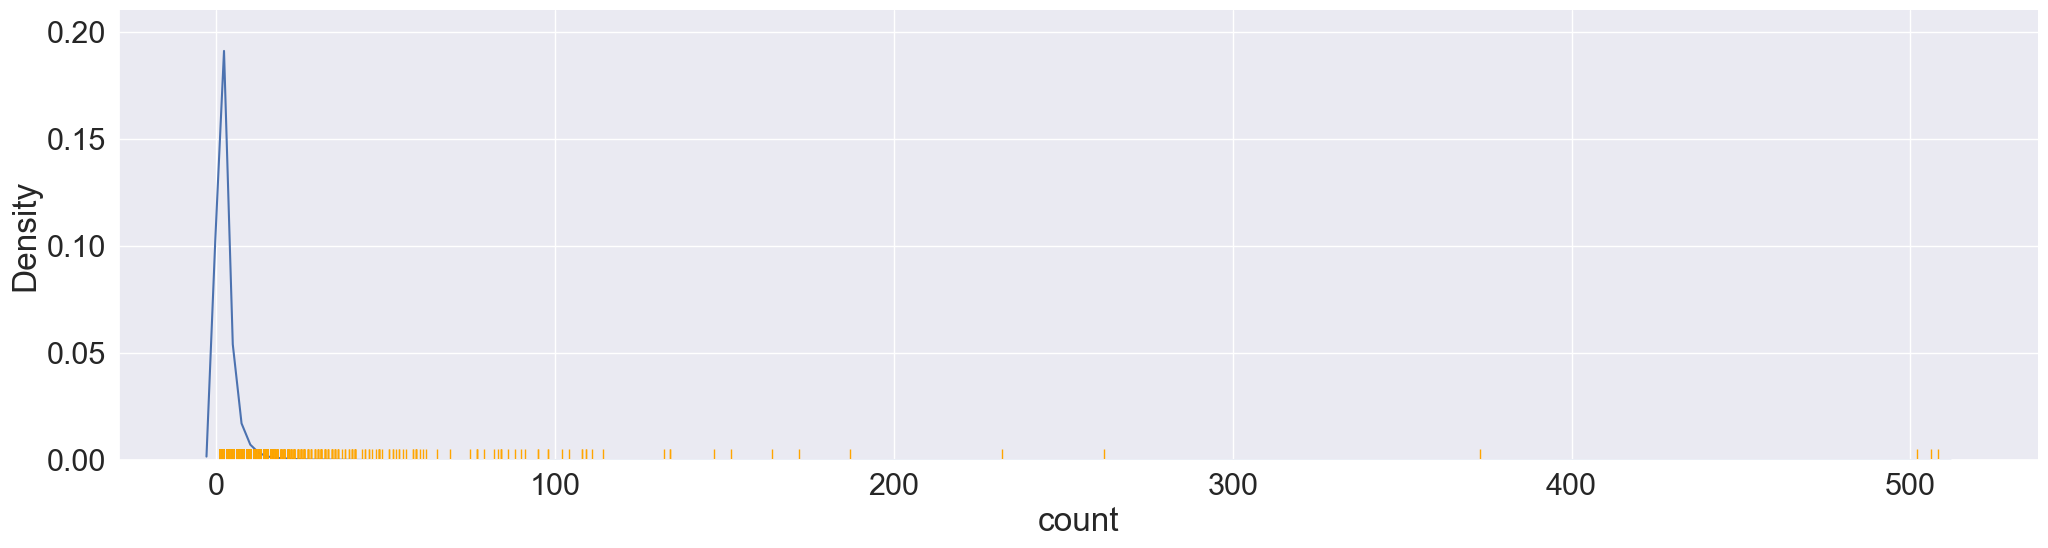

In [257]:
print("Value counts:")
print([(x,y) for (x,y) in df.subvillage.value_counts().items() if y==1])
# Demasiadas categorías de una sola aparición, crearé categoría de "poco frecuente" como recomendó el profesor y de la primera manera descrita en "Python Feature Engineering Cookbook"


freqs = df["subvillage"].value_counts(normalize=False)
freqs.sort_values(ascending=False)
# la categoría que más aparece, aparece sólo en el 0.8606% de los rows
sns.displot(freqs, height=6, aspect=3.5,kind='kde',rug=True, rug_kws={"color": "orange"})
freqs.loc[freqs!=1]


In [264]:
# En el libro se hace con frecuencias porcentuales, lo hago con números para ajustarlo de manera más fácil
frequent_cat = [
 x for x in freqs.loc[freqs > 3].index.values]

cramer = jd.cramers_v(df.subvillage,df.status_group)
print(f"Aosicación con la objetivo antes de agrupar categorías poco frecuentes: {cramer}")

# Agrupo las poco frecuentes
df["subvillage_agrupado"] = np.where(
 df["subvillage"].isin(frequent_cat),
 df["subvillage"], "Rare"
)
df.subvillage_agrupado = df.subvillage_agrupado.astype("category")
cramer = jd.cramers_v(df.subvillage_agrupado,df.status_group)
print(f"Aosicación con la objetivo después de agrupar categorías poco frecuentes: {cramer}")
"""
frequent_cat = [
 x for x in freqs.loc[freqs > 0.001].index.values]
Aosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041
Aosicación con la objetivo después de agrupar categorías poco frecuentes: 0.0585490865296918

Así como esta hice muchas iteraciones, lo que maximiza la asociación cramer es no agrupar, me quedo con la sin agrupar y con 3 porque el random forest no debería tener problemas con esto
"""

Aosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041
Aosicación con la objetivo después de agrupar categorías poco frecuentes: 0.4030543983122225


'\nfrequent_cat = [\n x for x in freqs.loc[freqs > 0.001].index.values]\nAosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041\nAosicación con la objetivo después de agrupar categorías poco frecuentes: 0.0585490865296918\n\nAsí como esta hice muchas iteraciones, lo que maximiza la asociación cramer es no agrupar, me quedo con la sin agrupar y con 3 porque el random forest no debería tener problemas con esto\n'

In [268]:
#asociaciones_df_var(df,"subvillage")
# en esta computadora recibo MemoryError: Unable to allocate 10.7 GiB for an array with shape (2, 721314513) and data type uint64, lo intentaré en la otra. Pero recuerdo que tenía fuerte asociación con las demás, por eso el IterativeImputer

## public_meeting

In [270]:
print(df.public_meeting.unique())
asociaciones_df_var(df,"public_meeting") # Fuerte asociación: IterativeImputer

[True, NaN, False]
Categories (2, bool): [False, True]
Top 10 asociaciones del df con public_meeting:
wpt_name               0.835721
scheme_name            0.801465
subvillage             0.792004
ward                   0.761752
lga                    0.518875
subvillage_agrupado    0.493667
installer              0.476018
funder                 0.460189
management             0.292456
scheme_management      0.268317
dtype: float64


## "scheme_management","scheme_name"

In [276]:
print(f"Cantidad de valores únicos en management: {df.scheme_management.nunique()},Cantidad de valores únicos en name: {df.scheme_name.nunique()}")
print(f"Asociaicón entre ambas;:{jd.cramers_v(df.scheme_management,df.scheme_name)}")
print("No parece que cada valor de name tenga un solo valor en management, no le haré drop a ninguno")

df[["scheme_management","scheme_name"]].loc[df["scheme_name"]=="Roman"].scheme_management.unique()
#df[["scheme_management","scheme_name"]] 



Cantidad de valores únicos en management: 11,Cantidad de valores únicos en name: 2695
Asociaicón entre ambas;:0.8485511131345878


['VWC', 'Water Board']
Categories (11, object): ['Company', 'Other', 'Parastatal', 'Private operator', ..., 'WUA', 'WUG', 'Water Board', 'Water authority']

In [ ]:
drop_list  = ["management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

In [278]:
asociaciones_df_var(df,"scheme_name")# Fuerte asociación: IterativeImputer
print("---------------------------------")
asociaciones_df_var(df,"scheme_management")# Fuerte asociación: IterativeImputer

Top 10 asociaciones del df con scheme_name:
region_code          0.998182
district_code        0.993101
permit               0.956034
basin                0.952137
region               0.950659
latitude             0.949884
lga                  0.946694
construction_year    0.943071
gps_height           0.915427
longitude            0.906763
dtype: float64
---------------------------------
Top 10 asociaciones del df con scheme_management:
wpt_name               0.864965
scheme_name            0.848551
subvillage             0.801570
management             0.793969
ward                   0.762417
management_group       0.700172
installer              0.644816
lga                    0.624297
funder                 0.618269
subvillage_agrupado    0.575758
dtype: float64


##  permit

In [283]:
df.permit.value_counts(dropna=False)

cramer = jd.cramers_v(df.permit,df.status_group) # Asociación muy baja con la objetivo, pero no es razón para descartarla
print(f"Aosicación con la Objetivo: {cramer}")

asociaciones_df_var(df,"permit")# Fuerte asociación: IterativeImputer

Aosicación con la Objetivo: 0.034686416172701455
Top 10 asociaciones del df con permit:
scheme_name            0.956034
ward                   0.892290
subvillage             0.834607
wpt_name               0.827077
lga                    0.822143
installer              0.642906
funder                 0.620634
subvillage_agrupado    0.555618
region                 0.408145
scheme_management      0.292884
dtype: float64


# Reviso ahora las categorías que en la descipción parecen significar lo mismo

basin - Geographic water basin
subvillage - Geographic location

In [292]:
print(f"Cantidad de valores únicos en basin: {df.basin.nunique()},Cantidad de valores únicos en subvillage: {df.subvillage.nunique()}")

df[["basin","subvillage"]].loc[df["subvillage"]=="Majengo"].basin.unique()

#No parece que se cumpla que cada valor de subvillage se corresponde a uno solo de basin, dejo ambas

#df[["basin","subvillage"]]

Cantidad de valores únicos en basin: 9,Cantidad de valores únicos en subvillage: 19287


['Pangani', 'Lake Nyasa', 'Lake Rukwa', 'Rufiji', 'Ruvuma / Southern Coast', 'Lake Tanganyika', 'Internal', 'Lake Victoria', 'Wami / Ruvu']
Categories (9, object): ['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika', ..., 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast', 'Wami / Ruvu']

region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)

In [306]:
print(f"Cantidad de valores únicos en region: {df.region.nunique()},Cantidad de valores únicos en region_code: {df.region_code.nunique()},Cantidad de valores únicos en district_code: {df.district_code.nunique()}")
df[["region","region_code","district_code"]]

df[["region_code","district_code"]].loc[df["region_code"]==20].district_code.unique() #No parece que se cumpla que cada valor de district_code se corresponde a uno solo de region_code, dejo ambas

Cantidad de valores únicos en region: 21,Cantidad de valores únicos en region_code: 27,Cantidad de valores únicos en district_code: 20


array([2, 3, 4, 1, 6], dtype=int64)

In [312]:
df[["region","region_code"]].loc[df["region_code"]==20].region.unique() 
# Para regiuon y region code sí parece que cada region code se corresponde a una sola region
df[["region","region_code"]].loc[df["region_code"]==21].region.unique() 
for i in df["region_code"].unique():
    if df[["region","region_code"]].loc[df["region_code"]==i].region.nunique() !=1:
        print(f"el code {i} se corresponde a más de una región")

df[["region_code","district_code"]].loc[df["region_code"]==11]#.district_code.unique() No le hago drop a ninguno de los tres con descripción "Geographic location"--> ojo: sólo aplica porque uso random forest


el code 11 se corresponde a más de una región
el code 18 se corresponde a más de una región
el code 17 se corresponde a más de una región
el code 14 se corresponde a más de una región
el code 5 se corresponde a más de una región


,region_code,district_code
0,11,5
16,11,4
17,11,4
19,11,5
20,11,4
...,...,...
59365,11,4
59367,11,3
59378,11,4
59380,11,5


lga - Geographic location
ward - Geographic location

In [315]:
print(f"Cantidad de valores únicos en lga: {df.lga.nunique()},Cantidad de valores únicos en region_code: {df.region_code.nunique()},Cantidad de valores únicos en ward: {df.ward.nunique()}")

df[["lga","ward"]]

Cantidad de valores únicos en lga: 125,Cantidad de valores únicos en region_code: 27,Cantidad de valores únicos en ward: 2092


,lga,ward
0,Ludewa,Mundindi
1,Serengeti,Natta
2,Simanjiro,Ngorika
3,Nanyumbu,Nanyumbu
4,Karagwe,Nyakasimbi
...,...,...
59395,Hai,Masama Magharibi
59396,Njombe,Ikondo
59397,Mbarali,Chimala
59398,Chamwino,Mvumi Makulu
